# January Anomaly

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from finance_byu import fama_macbeth
import cudf
from linearmodels import FamaMacBeth

this section is to calculate the January anomaly. I have refered the process in papers/The_January_Anomaly_and_Anomalies_in_January.pdf

In [2]:
# monthly_stock_return = pd.read_excel(r'source_data/Monthly Stock Price Returns/TRD_Mnth.xlsx')  # load the monthly stock price return data
# monthly_stock_return = monthly_stock_return.iloc[2:, :]
# monthly_stock_return = monthly_stock_return[['Stkcd', 'Trdmnt', 'Msmvttl', 'Mretwd']]
# monthly_stock_return.columns = ['Stkcd', 'month', 'market_value', 'monthly_stock_return']
# monthly_stock_return['month'] = pd.to_datetime(monthly_stock_return['month']).dt.to_period('M')
# monthly_stock_return.to_feather(r'temp/monthly_stock_return.feather')

In [3]:
# get monthly stock return data
monthly_stock_return = pd.read_feather(r'temp/monthly_stock_return.feather')  # load the monthly stock price return data
monthly_stock_return['market_value'] = monthly_stock_return['market_value'] * 1000  # change the unit of the market value to yuan
monthly_stock_return.head(10)

,Stkcd,month,market_value,monthly_stock_return
2,000001,2000-01,2.875573e+10,0.061891
3,000001,2000-02,2.842984e+10,-0.011333
4,000001,2000-03,2.850743e+10,0.002729
5,000001,2000-04,2.956269e+10,0.037017
6,000001,2000-05,2.793325e+10,-0.055118
7,000001,2000-06,2.813499e+10,0.007222
8,000001,2000-07,2.872469e+10,0.020960
9,000001,2000-08,2.754529e+10,-0.041059
10,000001,2000-09,2.631933e+10,-0.044507
11,000001,2000-10,2.723492e+10,0.034788


In [4]:
# load fama-french five factors data
factor_data = pd.read_excel(
    'source_data/5-Factor Model Index (Monthly)/STK_MKT_FIVEFACMONTH.xlsx')
factor_data = factor_data[
    ['MarkettypeID', 'TradingMonth', 'Portfolios', 'RiskPremium2', 'SMB2', 'HML2', 'RMW2', 'CMA2']]
factor_data.columns = ['MarkettypeID', 'date', 'portfolios', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']
factor_data = factor_data.iloc[2:, :]
factor_data = factor_data[factor_data['portfolios'] == 1]
factor_data = factor_data[
    factor_data['MarkettypeID'] == "P9706"]  # P9706: SSE-SZSE A share market (excluding STAR Market, ChiNext)
factor_data.reset_index(drop=True, inplace=True)  # reset the index to 0,1,2,...
factor_data = factor_data[['date', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']]
factor_data.columns = ['month', 'mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']
factor_data.head(10)

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,month,mkt_risk_premium,SMB,HML,RMW,CMA
0,2000-01,0.135225,-0.005175,-0.104151,0.042289,-0.076779
1,2000-02,0.113951,0.032327,-0.002393,-0.011365,0.03855
2,2000-03,0.058133,0.069624,0.01608,-0.051447,0.065904
3,2000-04,0.015578,-0.010779,0.02358,-0.022984,0.00972
4,2000-05,0.027197,0.025777,0.025355,-0.00662,-0.005409
5,2000-06,0.022145,-0.026737,0.032628,0.002911,0.002796
6,2000-07,0.044277,0.017068,0.03052,-0.002764,0.045901
7,2000-08,-0.008596,0.042098,-0.017277,-0.032858,0.013269
8,2000-09,-0.049773,0.028192,-0.034215,-0.003422,0.011796
9,2000-10,0.023503,0.032889,0.013666,0.001559,0.00692


In [5]:
"""
for we have momentum factor starting at 2000-12(because we select past 12 months to calculate momentum), we will only use data after 2000-12
"""
factor_data = factor_data[factor_data['month'] >= '2000-12']
factor_data['month'] = pd.to_datetime(factor_data['month']).dt.to_period('M')
factor_data.head(10)

,month,mkt_risk_premium,SMB,HML,RMW,CMA
11,2000-12,-0.002537,0.027538,0.013365,0.019526,-0.005541
12,2001-01,-0.009398,-0.009448,0.025946,0.004744,0.006877
13,2001-02,-0.059119,-0.012166,0.030485,0.024579,-0.011171
14,2001-03,0.07023,0.029589,0.005013,-0.006481,0.003347
15,2001-04,-0.006892,0.035411,-0.014138,-0.025686,0.010693
16,2001-05,0.034948,0.067417,0.002223,-0.02534,0.013096
17,2001-06,0.005902,-0.000522,0.006724,0.009211,0.011929
18,2001-07,-0.13411,-0.006747,-0.007594,-0.001881,0.006294
19,2001-08,-0.034982,0.015742,-0.010783,-0.004782,0.009822
20,2001-09,-0.049854,-0.026623,0.020785,0.01392,-0.012835


## 1.0 a simple view on market return

We will calculate some statistics of the market return of "all months", "January only" and "Non-January" to check whether January anomaly exists.

In [6]:
# import and clean the risk-free rate data
rf = pd.read_excel('source_data/Risk-Free Rate/TRD_Nrrate.xlsx')  # load the risk-free rate data
rf = rf.iloc[2:, :]
rf = rf[['Clsdt', 'Nrrdaydt','Nrrdata']]
rf.columns = ['date', 'daily_rf','rf']
rf['date'] = pd.to_datetime(rf['date'])
rf['daily_rf'] = rf['daily_rf'] / 100  # change the unit of the risk-free rate to decimal
rf['rf'] = rf['rf'] / 100  # change the unit of the risk-free rate to decimal
rf['month'] = rf['date'].dt.to_period('M')
rf_monthly = rf.groupby('month').agg({'daily_rf': [lambda x: (1 + x).prod() - 1], 'rf': 'last'})
rf_monthly.reset_index(inplace=True)
rf_monthly.columns = ['month', 'monthly_rf','rf']

# merge the risk-free rate data into monthly_stock_return
monthly_stock_return['rf'] = monthly_stock_return['month'].map(rf_monthly.set_index('month')['monthly_rf'])
monthly_stock_return['excess_return'] = monthly_stock_return['monthly_stock_return'] - monthly_stock_return['rf']
monthly_stock_return

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,month,market_value,monthly_stock_return,rf,excess_return
2,000001,2000-01,2.875573e+10,0.061891,0.001893,0.059998
3,000001,2000-02,2.842984e+10,-0.011333,0.001771,-0.013104
4,000001,2000-03,2.850743e+10,0.002729,0.001893,0.000836
5,000001,2000-04,2.956269e+10,0.037017,0.001832,0.035185
6,000001,2000-05,2.793325e+10,-0.055118,0.001893,-0.057011
...,...,...,...,...,...,...
730496,900957,2023-09,1.399490e+08,-0.067446,0.001231,-0.068677
730497,900957,2023-10,1.392510e+08,-0.004992,0.001272,-0.006264
730498,900957,2023-11,1.444860e+08,0.037596,0.001231,0.036365
730499,900957,2023-12,1.441370e+08,-0.002418,0.001272,-0.003690


In [7]:
return_stat = pd.DataFrame(index=['mean', 'median','std', 'min', 'max', '.01 quantile', '.25 quantile', '.5 quantile', '.75 quantile', '.99 quantile', 'skew', 'kurt'], columns=['all months', 'January only', 'Non-January'])

# calculate market return
tmp = monthly_stock_return.groupby(['month'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False)

# calculate market return of January
tmp_january = monthly_stock_return[monthly_stock_return['month'].dt.month == 1].groupby(['month'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False)

# calculate market return of non-January
tmp_non_january = monthly_stock_return[monthly_stock_return['month'].dt.month != 1].groupby(['month'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False)

return_stat.iloc[:, 0] = [tmp.mean(), tmp.median(),tmp.std(), tmp.min(), tmp.max(), tmp.quantile(0.01), tmp.quantile(0.25), tmp.quantile(0.5), tmp.quantile(0.75), tmp.quantile(0.99), tmp.skew(), tmp.kurt()]
return_stat.iloc[:, 1] = [tmp_january.mean(), tmp_january.median(),tmp_january.std(), tmp_january.min(), tmp_january.max(), tmp_january.quantile(0.01), tmp_january.quantile(0.25), tmp_january.quantile(0.5), tmp_january.quantile(0.75), tmp_january.quantile(0.99), tmp_january.skew(), tmp_january.kurt()]
return_stat.iloc[:, 2] = [tmp_non_january.mean(), tmp_non_january.median(),tmp_non_january.std(), tmp_non_january.min(), tmp_non_january.max(), tmp_non_january.quantile(0.01), tmp_non_january.quantile(0.25), tmp_non_january.quantile(0.5), tmp_non_january.quantile(0.75), tmp_non_january.quantile(0.99), tmp_non_january.skew(), tmp_non_january.kurt()]
return_stat.to_excel('output/part2/January Anomaly return stat.xlsx')
return_stat

,all months,January only,Non-January
mean,0.029418,0.053266,0.02684
median,0.019586,0.080492,0.016743
std,0.089393,0.074831,0.091336
min,-0.239869,-0.054796,-0.239869
max,0.20378,0.106873,0.20378
.01 quantile,-0.194725,-0.051324,-0.19924
.25 quantile,-0.019045,0.031996,-0.019045
.5 quantile,0.019586,0.080492,0.016743
.75 quantile,0.091564,0.101762,0.069777
.99 quantile,0.18903,0.106669,0.190505


## 1.1 construct momentum factor and reversal factor

In [8]:
# construct momentum tag
tmp = monthly_stock_return.groupby(['Stkcd'])['monthly_stock_return'].rolling(window=12).apply(lambda x: (1 + x).prod() - 1)
tmp = tmp.reset_index()
monthly_stock_return['momentum'] = tmp['monthly_stock_return']
monthly_stock_return.head(20)

,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum
2,000001,2000-01,2.875573e+10,0.061891,0.001893,0.059998,NaN
3,000001,2000-02,2.842984e+10,-0.011333,0.001771,-0.013104,NaN
4,000001,2000-03,2.850743e+10,0.002729,0.001893,0.000836,NaN
5,000001,2000-04,2.956269e+10,0.037017,0.001832,0.035185,NaN
6,000001,2000-05,2.793325e+10,-0.055118,0.001893,-0.057011,NaN
7,000001,2000-06,2.813499e+10,0.007222,0.001832,0.005390,NaN
8,000001,2000-07,2.872469e+10,0.020960,0.001893,0.019067,NaN
9,000001,2000-08,2.754529e+10,-0.041059,0.001893,-0.042952,NaN
10,000001,2000-09,2.631933e+10,-0.044507,0.001832,-0.046339,NaN
11,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442


In [9]:
# construct reversal tag
tmp = monthly_stock_return.groupby(['Stkcd'])['monthly_stock_return'].shift(1)
monthly_stock_return['reversal'] = tmp
monthly_stock_return.head(20)

,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum,reversal
2,000001,2000-01,2.875573e+10,0.061891,0.001893,0.059998,NaN,NaN
3,000001,2000-02,2.842984e+10,-0.011333,0.001771,-0.013104,NaN,0.061891
4,000001,2000-03,2.850743e+10,0.002729,0.001893,0.000836,NaN,-0.011333
5,000001,2000-04,2.956269e+10,0.037017,0.001832,0.035185,NaN,0.002729
6,000001,2000-05,2.793325e+10,-0.055118,0.001893,-0.057011,NaN,0.037017
7,000001,2000-06,2.813499e+10,0.007222,0.001832,0.005390,NaN,-0.055118
8,000001,2000-07,2.872469e+10,0.020960,0.001893,0.019067,NaN,0.007222
9,000001,2000-08,2.754529e+10,-0.041059,0.001893,-0.042952,NaN,0.020960
10,000001,2000-09,2.631933e+10,-0.044507,0.001832,-0.046339,NaN,-0.041059
11,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442,-0.044507


In [10]:
monthly_stock_return.dropna(inplace=True)
monthly_stock_return.head(20)

,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum,reversal
11,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442,-0.044507
12,000001,2000-11,3.014079e+10,0.010403,0.001832,0.008571,-0.074542,0.034788
13,000001,2000-12,2.825334e+10,-0.062621,0.001893,-0.064514,-0.119548,0.010403
14,000001,2001-01,2.914842e+10,0.031680,0.001893,0.029787,0.010792,-0.062621
15,000001,2001-02,2.741663e+10,-0.059413,0.001709,-0.061122,-0.066753,0.031680
16,000001,2001-03,3.156124e+10,0.151171,0.001893,0.149278,0.030297,-0.059413
17,000001,2001-04,3.021862e+10,-0.042540,0.001832,-0.044372,-0.033287,0.151171
18,000001,2001-05,3.152232e+10,0.043142,0.001893,0.041249,-0.144666,-0.042540
19,000001,2001-06,2.979054e+10,-0.054938,0.001832,-0.056770,-0.180276,0.043142
20,000001,2001-07,2.691072e+10,-0.096669,0.001893,-0.098562,-0.139394,-0.054938


In [11]:
# construct momentum factor
monthly_stock_return['momentum_tag'] = monthly_stock_return.groupby(['month'])['momentum'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['momentum_tag'] = monthly_stock_return['momentum_tag'].astype('category')
tmp = monthly_stock_return.groupby(['month', 'momentum_tag'], observed=False).apply(lambda x: np.average(x['monthly_stock_return'], weights=x['market_value']), include_groups=False).unstack()
tmp['momentum'] = tmp[9] - tmp[0]
factor_data = pd.merge(factor_data, tmp[['momentum']], left_on='month', right_index=True, how='left')
factor_data

,month,mkt_risk_premium,SMB,HML,RMW,CMA,momentum
11,2000-12,-0.002537,0.027538,0.013365,0.019526,-0.005541,0.081499
12,2001-01,-0.009398,-0.009448,0.025946,0.004744,0.006877,0.031181
13,2001-02,-0.059119,-0.012166,0.030485,0.024579,-0.011171,0.122182
14,2001-03,0.07023,0.029589,0.005013,-0.006481,0.003347,0.953559
15,2001-04,-0.006892,0.035411,-0.014138,-0.025686,0.010693,0.174047
...,...,...,...,...,...,...,...
284,2023-09,-0.002334,0.0091,0.015482,-0.00497,-0.003365,0.085094
285,2023-10,-0.02938,0.026882,-0.009619,-0.016592,-0.003727,0.079767
286,2023-11,-0.00157,0.052495,-0.008304,-0.021795,0.019977,0.066642
287,2023-12,-0.015435,0.005892,0.002136,0.019856,-0.014981,NaN


In [12]:
# construct reversal factor
monthly_stock_return['reversal_tag'] = monthly_stock_return.groupby(['month'])['reversal'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['reversal_tag'] = monthly_stock_return['reversal_tag'].astype('category')
tmp = monthly_stock_return.groupby(['month', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['monthly_stock_return'], weights=x['market_value']), include_groups=False).unstack()
tmp['reversal'] = tmp[9] - tmp[0]
factor_data = pd.merge(factor_data, tmp[['reversal']], left_on='month', right_index=True, how='left')
factor_data

,month,mkt_risk_premium,SMB,HML,RMW,CMA,momentum,reversal
11,2000-12,-0.002537,0.027538,0.013365,0.019526,-0.005541,0.081499,0.025962
12,2001-01,-0.009398,-0.009448,0.025946,0.004744,0.006877,0.031181,-0.002813
13,2001-02,-0.059119,-0.012166,0.030485,0.024579,-0.011171,0.122182,0.026262
14,2001-03,0.07023,0.029589,0.005013,-0.006481,0.003347,0.953559,0.144483
15,2001-04,-0.006892,0.035411,-0.014138,-0.025686,0.010693,0.174047,0.120744
...,...,...,...,...,...,...,...,...
284,2023-09,-0.002334,0.0091,0.015482,-0.00497,-0.003365,0.085094,0.007729
285,2023-10,-0.02938,0.026882,-0.009619,-0.016592,-0.003727,0.079767,0.080820
286,2023-11,-0.00157,0.052495,-0.008304,-0.021795,0.019977,0.066642,0.006310
287,2023-12,-0.015435,0.005892,0.002136,0.019856,-0.014981,NaN,NaN


## 1.2 way 1:  run regression for January and non-January group

Firstly, I will run the regression below with "all month", "January Only" and "Non-January" data to check whether January anomaly exists.
$$EXRET_{i,t} = \alpha + b_i MKTRP_t + c_i SMB_t + d_i HML_t +e_i RMW_t + g_i CMA_t + \epsilon_{i,t}$$

### 1.2.1 get sorted portfolio tag

we will sort all the stocks into 10 groups based on different indicators: momentum, reversal, market value, book-to-market ratio, size, and then calculate the average return of each group. Then we will run the regression above to check whether January anomaly exists.

In [13]:
# sort based on size
monthly_stock_return['size_tag'] = monthly_stock_return.groupby(['month'])['market_value'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['size_tag'] = monthly_stock_return['size_tag'].astype('category')
monthly_stock_return.head(10)

,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum,reversal,momentum_tag,reversal_tag,size_tag
11,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442,-0.044507,0,5,9
12,000001,2000-11,3.014079e+10,0.010403,0.001832,0.008571,-0.074542,0.034788,0,4,9
13,000001,2000-12,2.825334e+10,-0.062621,0.001893,-0.064514,-0.119548,0.010403,1,1,9
14,000001,2001-01,2.914842e+10,0.031680,0.001893,0.029787,0.010792,-0.062621,2,1,9
15,000001,2001-02,2.741663e+10,-0.059413,0.001709,-0.061122,-0.066753,0.031680,1,7,9
16,000001,2001-03,3.156124e+10,0.151171,0.001893,0.149278,0.030297,-0.059413,2,5,9
17,000001,2001-04,3.021862e+10,-0.042540,0.001832,-0.044372,-0.033287,0.151171,1,7,9
18,000001,2001-05,3.152232e+10,0.043142,0.001893,0.041249,-0.144666,-0.042540,2,2,9
19,000001,2001-06,2.979054e+10,-0.054938,0.001832,-0.056770,-0.180276,0.043142,2,4,9
20,000001,2001-07,2.691072e+10,-0.096669,0.001893,-0.098562,-0.139394,-0.054938,3,1,9


In [14]:
# sort based on book-to-market ratio

# this procedure is the same in part1
balance_sheet = pd.read_csv(r'source_data/Balance Sheet/balance_sheet.csv')  # load the balance sheet data
balance_sheet = balance_sheet[balance_sheet['Statement Type'] == "A"]
balance_sheet = balance_sheet[['Stock Code', 'Ending Date of Statistics', 'Total Assets', 'Total Shareholders’ Equity']]
balance_sheet.columns = ['Stkcd', 'date', 'total_assets', 'total_shareholders_equity']
balance_sheet = balance_sheet.iloc[1:, :]
balance_sheet['date'] = pd.to_datetime(balance_sheet['date'])
balance_sheet['month'] = balance_sheet['date'].dt.to_period('M')
balance_sheet = balance_sheet[['Stkcd', 'month', 'total_assets', 'total_shareholders_equity']]
monthly_stock_return = monthly_stock_return.merge(balance_sheet, left_on=['Stkcd', 'month'],
                                                  right_on=['Stkcd', 'month'], how='left')
monthly_stock_return['total_assets'] = monthly_stock_return['total_assets'].ffill().astype(
    np.float64)  # ffill means use the value of the last row to fill the missing value
monthly_stock_return['total_shareholders_equity'] = monthly_stock_return['total_shareholders_equity'].ffill().astype(
    np.float64)
monthly_stock_return['BM ratio'] = monthly_stock_return['total_shareholders_equity'] / monthly_stock_return[
    'market_value']  # calculate the book-to-market ratio

monthly_stock_return['bm_tag'] = monthly_stock_return.groupby(['month'])['BM ratio'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
monthly_stock_return['bm_tag'] = monthly_stock_return['bm_tag'].astype('category')
monthly_stock_return.head(10)

/tmp/ipykernel_19732/2812200323.py:4: DtypeWarning: Columns (1,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  balance_sheet = pd.read_csv(r'source_data/Balance Sheet/balance_sheet.csv')  # load the balance sheet data


,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum,reversal,momentum_tag,reversal_tag,size_tag,total_assets,total_shareholders_equity,BM ratio,bm_tag
0,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442,-0.044507,0,5,9,NaN,NaN,NaN,NaN
1,000001,2000-11,3.014079e+10,0.010403,0.001832,0.008571,-0.074542,0.034788,0,4,9,NaN,NaN,NaN,NaN
2,000001,2000-12,2.825334e+10,-0.062621,0.001893,-0.064514,-0.119548,0.010403,1,1,9,6.722750e+10,4.738884e+09,0.167728,1.0
3,000001,2001-01,2.914842e+10,0.031680,0.001893,0.029787,0.010792,-0.062621,2,1,9,6.600617e+10,3.517551e+09,0.120677,0.0
4,000001,2001-02,2.741663e+10,-0.059413,0.001709,-0.061122,-0.066753,0.031680,1,7,9,6.600617e+10,3.517551e+09,0.128300,0.0
5,000001,2001-03,3.156124e+10,0.151171,0.001893,0.149278,0.030297,-0.059413,2,5,9,6.600617e+10,3.517551e+09,0.111452,0.0
6,000001,2001-04,3.021862e+10,-0.042540,0.001832,-0.044372,-0.033287,0.151171,1,7,9,6.600617e+10,3.517551e+09,0.116403,0.0
7,000001,2001-05,3.152232e+10,0.043142,0.001893,0.041249,-0.144666,-0.042540,2,2,9,6.600617e+10,3.517551e+09,0.111589,0.0
8,000001,2001-06,2.979054e+10,-0.054938,0.001832,-0.056770,-0.180276,0.043142,2,4,9,8.518143e+10,4.961824e+09,0.166557,1.0
9,000001,2001-07,2.691072e+10,-0.096669,0.001893,-0.098562,-0.139394,-0.054938,3,1,9,8.518143e+10,4.961824e+09,0.184381,1.0


In [15]:
# sort based on ROE (op), RMW
def ten_division(x):
    edge1, edge2, edge3, edge4, edge5, edge6, edge7, edge8, edge9 = x.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    tmp = x.apply(lambda x: 0 if x <= edge1 else 1 if x <= edge2 else 2 if x <= edge3 else 3 if x <= edge4 else 4 if x <= edge5 else 5 if x <= edge6 else 6 if x <= edge7 else 7 if x <= edge8 else 8 if x <= edge9 else 9)
    return tmp
    

# the procedure is the same as in part1
income_statement = pd.read_excel(
    'source_data/Income Statement/FS_Comins.xlsx')  # load the income statement data, a little time-consuming, 23s
income_statement = income_statement[income_statement['Typrep'] == 'A']
income_statement = income_statement.iloc[2:, :]
income_statement = income_statement[['Stkcd', 'Accper', 'B002000000']]
income_statement.columns = ['Stkcd', 'date', 'net_income']
income_statement['date'] = pd.to_datetime(income_statement['date'])
income_statement['month'] = income_statement['date'].dt.to_period('M')
income_statement = income_statement[['Stkcd', 'month', 'net_income']]

# merge balance sheet and income statement data
balance_sheet = balance_sheet.merge(income_statement, on=['Stkcd', 'month'], how='left')
balance_sheet['net_income'] = balance_sheet['net_income'].ffill().astype(np.float64)
balance_sheet['total_shareholders_equity'] = balance_sheet['total_shareholders_equity'].astype(np.float64)
balance_sheet['ROE'] = balance_sheet['net_income'] / balance_sheet['total_shareholders_equity']
balance_sheet['ROE'] = balance_sheet['ROE'].replace([np.inf, -np.inf], np.nan)
balance_sheet['ROE'] = balance_sheet['ROE'].fillna(0)

balance_sheet['ROE_tag'] = balance_sheet.groupby("month")['ROE'].transform(
    ten_division)  # divide the stocks into 10 groups according to the ROE
balance_sheet['ROE_tag'] = balance_sheet['ROE_tag'].astype('category')

monthly_stock_return = monthly_stock_return.merge(balance_sheet[['Stkcd', 'month', 'ROE', 'ROE_tag']],
                                                  left_on=['Stkcd', 'month'], right_on=['Stkcd', 'month'], how='left')
monthly_stock_return['ROE'] = monthly_stock_return['ROE'].ffill()
monthly_stock_return['ROE_tag'] = monthly_stock_return['ROE_tag'].ffill()
monthly_stock_return.head(20)

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipykernel_19732/2058103186.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  balance_sheet['net_income'] = balance_sheet['net_income'].ffill().astype(np.float64)


,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum,reversal,momentum_tag,reversal_tag,size_tag,total_assets,total_shareholders_equity,BM ratio,bm_tag,ROE,ROE_tag
0,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442,-0.044507,0,5,9,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,3.014079e+10,0.010403,0.001832,0.008571,-0.074542,0.034788,0,4,9,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,2.825334e+10,-0.062621,0.001893,-0.064514,-0.119548,0.010403,1,1,9,6.722750e+10,4.738884e+09,0.167728,1.0,0.106893,2
3,000001,2001-01,2.914842e+10,0.031680,0.001893,0.029787,0.010792,-0.062621,2,1,9,6.600617e+10,3.517551e+09,0.120677,0.0,0.131619,2
4,000001,2001-02,2.741663e+10,-0.059413,0.001709,-0.061122,-0.066753,0.031680,1,7,9,6.600617e+10,3.517551e+09,0.128300,0.0,0.131619,2
5,000001,2001-03,3.156124e+10,0.151171,0.001893,0.149278,0.030297,-0.059413,2,5,9,6.600617e+10,3.517551e+09,0.111452,0.0,0.131619,2
6,000001,2001-04,3.021862e+10,-0.042540,0.001832,-0.044372,-0.033287,0.151171,1,7,9,6.600617e+10,3.517551e+09,0.116403,0.0,0.131619,2
7,000001,2001-05,3.152232e+10,0.043142,0.001893,0.041249,-0.144666,-0.042540,2,2,9,6.600617e+10,3.517551e+09,0.111589,0.0,0.131619,2
8,000001,2001-06,2.979054e+10,-0.054938,0.001832,-0.056770,-0.180276,0.043142,2,4,9,8.518143e+10,4.961824e+09,0.166557,1.0,0.044986,2
9,000001,2001-07,2.691072e+10,-0.096669,0.001893,-0.098562,-0.139394,-0.054938,3,1,9,8.518143e+10,4.961824e+09,0.184381,1.0,0.044986,2


In [16]:
# sort based on CMA (conservative minus aggressive, a measure of investment)
# the procedure is the same as in part1
balance_sheet['total_assets'] = balance_sheet['total_assets'].astype(np.float64)
balance_sheet['total_assets'] = balance_sheet['total_assets'].fillna(0)
balance_sheet['assets_increasing_rate'] = balance_sheet.groupby('Stkcd')[
    'total_assets'].pct_change()  # calculate the increasing rate of total assets
balance_sheet['assets_increasing_rate'] = balance_sheet['assets_increasing_rate'].replace([np.inf, -np.inf], np.nan)
balance_sheet['INV_tag'] = balance_sheet.groupby("month")['assets_increasing_rate'].transform(
    ten_division)  # divide the stocks into 10 groups according to the increasing rate of total assets
balance_sheet['INV_tag'] = balance_sheet['INV_tag'].astype(np.int64)
balance_sheet['INV_tag'] = balance_sheet['INV_tag'].astype('category')

# merge INV_tag information into monthly_stock_return
monthly_stock_return = monthly_stock_return.merge(
    balance_sheet[['Stkcd', 'month', 'assets_increasing_rate', 'INV_tag']],
    left_on=['Stkcd', 'month'], right_on=['Stkcd', 'month'], how='left')
monthly_stock_return['INV_tag'] = monthly_stock_return['INV_tag'].ffill()
monthly_stock_return['assets_increasing_rate'] = monthly_stock_return['assets_increasing_rate'].ffill()
monthly_stock_return.head(20)

,Stkcd,month,market_value,monthly_stock_return,rf,excess_return,momentum,reversal,momentum_tag,reversal_tag,size_tag,total_assets,total_shareholders_equity,BM ratio,bm_tag,ROE,ROE_tag,assets_increasing_rate,INV_tag
0,000001,2000-10,2.723492e+10,0.034788,0.001893,0.032895,-0.047442,-0.044507,0,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,3.014079e+10,0.010403,0.001832,0.008571,-0.074542,0.034788,0,4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,2.825334e+10,-0.062621,0.001893,-0.064514,-0.119548,0.010403,1,1,9,6.722750e+10,4.738884e+09,0.167728,1.0,0.106893,2,0.351786,8
3,000001,2001-01,2.914842e+10,0.031680,0.001893,0.029787,0.010792,-0.062621,2,1,9,6.600617e+10,3.517551e+09,0.120677,0.0,0.131619,2,-0.018167,3
4,000001,2001-02,2.741663e+10,-0.059413,0.001709,-0.061122,-0.066753,0.031680,1,7,9,6.600617e+10,3.517551e+09,0.128300,0.0,0.131619,2,-0.018167,3
5,000001,2001-03,3.156124e+10,0.151171,0.001893,0.149278,0.030297,-0.059413,2,5,9,6.600617e+10,3.517551e+09,0.111452,0.0,0.131619,2,-0.018167,3
6,000001,2001-04,3.021862e+10,-0.042540,0.001832,-0.044372,-0.033287,0.151171,1,7,9,6.600617e+10,3.517551e+09,0.116403,0.0,0.131619,2,-0.018167,3
7,000001,2001-05,3.152232e+10,0.043142,0.001893,0.041249,-0.144666,-0.042540,2,2,9,6.600617e+10,3.517551e+09,0.111589,0.0,0.131619,2,-0.018167,3
8,000001,2001-06,2.979054e+10,-0.054938,0.001832,-0.056770,-0.180276,0.043142,2,4,9,8.518143e+10,4.961824e+09,0.166557,1.0,0.044986,2,0.290507,8
9,000001,2001-07,2.691072e+10,-0.096669,0.001893,-0.098562,-0.139394,-0.054938,3,1,9,8.518143e+10,4.961824e+09,0.184381,1.0,0.044986,2,0.290507,8


In [17]:
# rearrange the columns for better view
monthly_stock_return = monthly_stock_return[['Stkcd', 'month', 'monthly_stock_return','rf','excess_return', 'market_value','total_assets', 'total_shareholders_equity', 'BM ratio','ROE', 'assets_increasing_rate', 'momentum', 'reversal', 'size_tag', 'ROE_tag', 'bm_tag', 'INV_tag', 'momentum_tag', 'reversal_tag']]
monthly_stock_return.head(20)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,assets_increasing_rate,momentum,reversal,size_tag,ROE_tag,bm_tag,INV_tag,momentum_tag,reversal_tag
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,NaN,-0.047442,-0.044507,9,NaN,NaN,NaN,0,5
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,NaN,-0.074542,0.034788,9,NaN,NaN,NaN,0,4
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,0.351786,-0.119548,0.010403,9,2,1.0,8,1,1
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,-0.018167,0.010792,-0.062621,9,2,0.0,3,2,1
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,-0.018167,-0.066753,0.031680,9,2,0.0,3,1,7
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,-0.018167,0.030297,-0.059413,9,2,0.0,3,2,5
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,-0.018167,-0.033287,0.151171,9,2,0.0,3,1,7
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,-0.018167,-0.144666,-0.042540,9,2,0.0,3,2,2
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,0.290507,-0.180276,0.043142,9,2,1.0,8,2,4
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,0.290507,-0.139394,-0.054938,9,2,1.0,8,3,1


In [18]:
# monthly_stock_return.dropna(inplace=True)
monthly_stock_return.dtypes

Stkcd                           object
month                        period[M]
monthly_stock_return           float64
rf                             float64
excess_return                  float64
market_value                   float64
total_assets                   float64
total_shareholders_equity      float64
BM ratio                       float64
ROE                            float64
assets_increasing_rate         float64
momentum                       float64
reversal                       float64
size_tag                      category
ROE_tag                       category
bm_tag                        category
INV_tag                       category
momentum_tag                  category
reversal_tag                  category
dtype: object

### 1.2.2 calculate the average return of each group

In [19]:
"""
    calculate the value-weighted average return of each group
"""

# size
vw_size_group = monthly_stock_return.groupby(['month', 'size_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_size_group = vw_size_group.reset_index()


# BM ratio
vw_bm_group = monthly_stock_return.groupby(['month', 'bm_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_bm_group = vw_bm_group.reset_index()


# ROE
vw_ROE_group = monthly_stock_return.groupby(['month', 'ROE_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_ROE_group = vw_ROE_group.reset_index()


# INV
vw_INV_group = monthly_stock_return.groupby(['month', 'INV_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_INV_group = vw_INV_group.reset_index()


# momentum
vw_momentum_group = monthly_stock_return.groupby(['month', 'momentum_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_momentum_group = vw_momentum_group.reset_index()


# reversal
vw_reversal_group = monthly_stock_return.groupby(['month', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_reversal_group = vw_reversal_group.reset_index()
vw_reversal_group

reversal_tag,month,0,1,2,3,4,5,6,7,8,9
0,2000-10,0.020885,0.030591,0.015948,0.033026,0.030378,0.011302,0.011986,0.023280,0.043007,0.041307
1,2000-11,0.072580,0.055971,0.063980,0.068315,0.063734,0.070156,0.068290,0.066244,0.048222,0.039977
2,2000-12,-0.017344,-0.016339,0.006879,-0.005907,-0.003628,0.025690,0.000676,0.001385,-0.008282,0.008618
3,2001-01,-0.016466,-0.006932,0.008384,0.014832,-0.002879,-0.000730,-0.019273,-0.027865,-0.026423,-0.019279
4,2001-02,-0.059316,-0.066358,-0.067147,-0.066761,-0.061965,-0.071800,-0.055480,-0.054455,-0.036749,-0.033053
...,...,...,...,...,...,...,...,...,...,...,...
273,2023-07,0.021749,0.031434,0.055354,0.063045,0.051183,0.066324,0.030161,0.045351,0.003098,-0.046219
274,2023-08,-0.028708,-0.042625,-0.039724,-0.061474,-0.037245,-0.060360,-0.050410,-0.053113,-0.054719,-0.061657
275,2023-09,-0.008581,-0.009233,-0.007256,0.001801,0.003367,0.004053,-0.006826,-0.015923,-0.004687,-0.000852
276,2023-10,-0.047583,-0.017980,-0.020441,-0.030387,-0.018819,-0.010993,-0.014129,-0.025941,-0.018829,0.033236


In [20]:
"""
    calculate the equal-weighted average return of each group
"""

# size
ew_size_group = monthly_stock_return.groupby(['month', 'size_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_size_group = ew_size_group.reset_index()


# BM ratio
ew_bm_group = monthly_stock_return.groupby(['month', 'bm_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_bm_group = ew_bm_group.reset_index()


# ROE
ew_ROE_group = monthly_stock_return.groupby(['month', 'ROE_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_ROE_group = ew_ROE_group.reset_index()


# INV
ew_INV_group = monthly_stock_return.groupby(['month', 'INV_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_INV_group = ew_INV_group.reset_index()


# momentum
ew_momentum_group = monthly_stock_return.groupby(['month', 'momentum_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_momentum_group = ew_momentum_group.reset_index()


# reversal
ew_reversal_group = monthly_stock_return.groupby(['month', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_reversal_group = ew_reversal_group.reset_index()
ew_reversal_group

reversal_tag,month,0,1,2,3,4,5,6,7,8,9
0,2000-10,0.039907,0.047652,0.046478,0.045337,0.044300,0.031036,0.029194,0.033691,0.046538,0.038065
1,2000-11,0.061086,0.060479,0.067698,0.062384,0.066694,0.066789,0.062528,0.069828,0.059469,0.044025
2,2000-12,-0.002134,0.022703,0.029109,0.019631,0.026408,0.027303,0.014322,0.026734,0.023074,0.043209
3,2001-01,-0.011780,-0.011858,-0.003511,0.009098,-0.005389,-0.004991,-0.022071,-0.026245,-0.024031,-0.035008
4,2001-02,-0.070917,-0.059575,-0.056408,-0.062564,-0.058779,-0.062182,-0.055578,-0.051977,-0.046228,-0.053009
...,...,...,...,...,...,...,...,...,...,...,...
273,2023-07,-0.001746,0.008146,0.035207,0.042814,0.037976,0.032801,0.028014,0.005612,-0.016360,-0.060634
274,2023-08,-0.021775,-0.034549,-0.032191,-0.049520,-0.042044,-0.043678,-0.042739,-0.054299,-0.056861,-0.061912
275,2023-09,-0.009140,-0.007983,0.000919,0.005892,0.003492,0.002653,0.002845,0.006259,0.005032,-0.014197
276,2023-10,-0.035969,-0.020921,-0.022646,-0.014720,-0.019475,-0.009004,-0.002374,0.000326,0.004573,0.004877


### 1.2.3 run the regression

$$EXRET_{i,t} = \alpha + b_i MKTRP_t + c_i SMB_t + d_i HML_t +e_i RMW_t + g_i CMA_t + \epsilon_{i,t}$$

In [21]:
def regress(data, factors):
    result = pd.DataFrame(columns=['D1', 'D10', 'D10-D1', 'D1(January only)', 'D10(January only)', 'D10-D1(January only)', 'D1(non-January only)', 'D10(non-January only)', 'D10-D1(non-January only)'], index=['alpha', 't-alpha'])
    
    # All months
    y = data[0].to_numpy()
    x = factors[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 0] = model.params[0]
    result.iloc[1, 0] = model.tvalues[0]
    
    y = data[9].to_numpy()
    x = factors[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 1] = model.params[0]
    result.iloc[1, 1] = model.tvalues[0]
    
    y = (data[9] - data[0]).to_numpy()
    x = factors[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 2] = model.params[0]
    result.iloc[1, 2] = model.tvalues[0]
    
    # January only
    y = data[data['month'].dt.month == 1][0].to_numpy()
    x = factors[factors['month'].dt.month == 1][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 3] = model.params[0]
    result.iloc[1, 3] = model.tvalues[0]
    
    y = data[data['month'].dt.month == 1][9].to_numpy()
    x = factors[factors['month'].dt.month == 1][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 4] = model.params[0]
    result.iloc[1, 4] = model.tvalues[0]
    
    y = (data[data['month'].dt.month == 1][9] - data[data['month'].dt.month == 1][0]).to_numpy()
    x = factors[factors['month'].dt.month == 1][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 5] = model.params[0]
    result.iloc[1, 5] = model.tvalues[0]
    
    # non-January only
    y = data[data['month'].dt.month != 1][0].to_numpy()
    x = factors[factors['month'].dt.month != 1][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 6] = model.params[0]
    result.iloc[1, 6] = model.tvalues[0]
    
    y = data[data['month'].dt.month != 1][9].to_numpy()
    x = factors[factors['month'].dt.month != 1][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 7] = model.params[0]
    result.iloc[1, 7] = model.tvalues[0]
    
    y = (data[data['month'].dt.month != 1][9] - data[data['month'].dt.month != 1][0]).to_numpy()
    x = factors[factors['month'].dt.month != 1][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 8] = model.params[0]
    result.iloc[1, 8] = model.tvalues[0]
    return result

In [22]:
vw_bm_group.head()

bm_tag,month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
0,2000-10,0.011800,0.020171,0.013774,0.026198,0.033247,0.038233,0.045083,0.052457,0.031891,0.042336
1,2000-11,0.062027,0.062756,0.069430,0.059116,0.061672,0.069719,0.058993,0.050469,0.057997,0.087948
2,2000-12,-0.022463,-0.005315,0.002132,-0.014481,0.009895,0.017991,0.013308,0.009381,0.014562,0.159365
3,2001-01,-0.028153,-0.017233,0.006496,0.000912,-0.002560,-0.010621,0.001447,-0.022829,-0.030228,-0.015192
4,2001-02,-0.060822,-0.074616,-0.054099,-0.045395,-0.057126,-0.046875,-0.050755,-0.069197,-0.082674,-0.011601


In [23]:
result_vw_size_group = regress(vw_size_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_vw_bm_group = regress(vw_bm_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_vw_roe_group = regress(vw_ROE_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_vw_INV_group = regress(vw_INV_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_vw_momentum_group = regress(vw_momentum_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_vw_reversal_group = regress(vw_reversal_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])

In [24]:
# concat all variables vertically
tmp = pd.concat([result_vw_size_group, result_vw_bm_group, result_vw_roe_group, result_vw_INV_group, result_vw_momentum_group, result_vw_reversal_group], axis=0)
tmp.index = ['size','t-size', 'bm','t-bm', 'ROE','t-roe', 'INV','t-INV', 'momentum', 't-momentum', 'reversal', 't-reversal']
tmp

,D1,D10,D10-D1,D1(January only),D10(January only),D10-D1(January only),D1(non-January only),D10(non-January only),D10-D1(non-January only)
size,-0.013301,0.01428,0.027582,-0.004342,0.020331,0.024673,-0.014039,0.013889,0.027928
t-size,-4.009104,13.930037,7.936026,-0.803774,3.506866,3.680017,-3.907999,13.895378,7.42475
bm,0.015006,-0.013101,-0.028107,0.016568,-0.005857,-0.022426,0.015056,-0.013641,-0.028697
t-bm,13.008945,-4.514778,-9.275228,2.995526,-1.064181,-3.640911,12.9082,-4.360959,-8.764504
ROE,0.006897,0.009173,0.00124,0.016707,-0.007432,-0.022085,0.006332,0.009576,0.002695
t-roe,2.044573,0.590881,0.076088,2.687035,-0.413847,-0.988755,1.738456,0.547598,0.147091
INV,0.01025,0.025454,0.015204,0.018663,0.034248,0.015585,0.009742,0.025563,0.015821
t-INV,10.547884,4.449798,2.731285,3.175376,2.741446,1.638639,10.669032,4.171018,2.62966
momentum,-0.032796,0.074192,0.106988,-0.023113,0.070577,0.09369,-0.033963,0.074633,0.108597
t-momentum,-14.086018,12.072465,15.139219,-2.453576,4.726774,4.597942,-14.04338,11.318222,14.410007


In [25]:
tmp.to_excel('output/part2/January Anomaly table 3 panel A.xlsx')

In [26]:
result_ew_size_group = regress(ew_size_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_ew_bm_group = regress(ew_bm_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_ew_roe_group = regress(ew_ROE_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_ew_INV_group = regress(ew_INV_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_ew_momentum_group = regress(ew_momentum_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])
result_ew_reversal_group = regress(ew_reversal_group.iloc[2:,:], factor_data[factor_data['month'] <= '2023-11'])

tmp = pd.concat([result_ew_size_group, result_ew_bm_group, result_ew_roe_group, result_ew_INV_group, result_ew_momentum_group, result_ew_reversal_group], axis=0)
tmp.index = ['size','t-size', 'bm','t-bm', 'ROE','t-roe', 'INV','t-INV', 'momentum', 't-momentum', 'reversal', 't-reversal']
tmp

,D1,D10,D10-D1,D1(January only),D10(January only),D10-D1(January only),D1(non-January only),D10(non-January only),D10-D1(non-January only)
size,-0.010408,0.015362,0.025769,0.003733,0.025868,0.022135,-0.011779,0.014612,0.026391
t-size,-2.724789,9.969001,6.271315,0.439369,3.189879,2.210986,-2.881167,9.629474,6.007255
bm,0.015758,-0.00977,-0.025528,0.021347,0.003459,-0.017888,0.015445,-0.011054,-0.026499
t-bm,8.815096,-2.529603,-6.119213,2.856205,0.38776,-1.5827,8.344415,-2.676147,-5.974886
ROE,-0.003003,0.000721,0.002517,0.003151,-0.008928,-0.010506,-0.003267,0.000305,0.002324
t-roe,-1.886133,0.054418,0.190447,0.582983,-0.49412,-0.51527,-1.974163,0.020486,0.157028
INV,0.001539,0.010433,0.008894,0.013893,0.014104,0.00021,0.000662,0.010624,0.009961
t-INV,1.199238,2.28134,1.927047,2.290924,1.520109,0.027385,0.52113,2.157319,1.993234
momentum,-0.037529,0.066301,0.10383,-0.022808,0.066765,0.089572,-0.038618,0.066242,0.10486
t-momentum,-18.255693,13.868199,18.306136,-2.924847,5.014399,5.122658,-18.153552,12.963887,17.370537


In [27]:
tmp.to_excel('output/part2/January Anomaly table 3 panel B.xlsx')

the output above is just like table 3 in the paper, but the difference is that we use Fama-French 5-factor model while the paper used Fama-French 3-factor model

## 1.3 way 2: Fama-Macbeth Regression

Fama-Macbeth regression is a two-step procedure. You can refer this method here [Fama and Macbeth, 1973](papers/Fama-Macbeth-1973.pdf) 

In the first step, we run the cross-sectional regression:
$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{t}+\beta_{3,t}BM_{t}+\beta_{5,t}ROE_{t}+\beta_{7,t}INV_{t}+\beta_{9,t}MOM_{t}+\beta_{11,t}REV_{t}+\beta_{13,t}MRKRP_{t}+e_{i,t+1}$$

Then we can get the time-series average of the coefficients:
$$\bar{\beta_i}=\frac{1}{T}\sum_{t=1}^{T}\beta_{i,t}$$

Also, we can get  Standard errors, t-statistics, and p-values calculated using the Newey and West (1987) adjustment with six lags.

It should be pointed out that, the Fama-Macbeth regression introduction on Wikipedia [here](https://en.wikipedia.org/wiki/Fama%E2%80%93MacBeth_regression) and other websites are **wrong** !! And the module in Stata and Python are right. [Here](https://bbs.pinggu.org/thread-2321958-1-1.html) shows some debate over the two versions of Fama-Macbeth regression.

here we use the module powered by BYU, you can refer the module official website [here](https://fin-library.readthedocs.io/en/latest/contents.html)

In [28]:
factor_data.head(10)

,month,mkt_risk_premium,SMB,HML,RMW,CMA,momentum,reversal
11,2000-12,-0.002537,0.027538,0.013365,0.019526,-0.005541,0.081499,0.025962
12,2001-01,-0.009398,-0.009448,0.025946,0.004744,0.006877,0.031181,-0.002813
13,2001-02,-0.059119,-0.012166,0.030485,0.024579,-0.011171,0.122182,0.026262
14,2001-03,0.07023,0.029589,0.005013,-0.006481,0.003347,0.953559,0.144483
15,2001-04,-0.006892,0.035411,-0.014138,-0.025686,0.010693,0.174047,0.120744
16,2001-05,0.034948,0.067417,0.002223,-0.02534,0.013096,0.177229,0.087472
17,2001-06,0.005902,-0.000522,0.006724,0.009211,0.011929,-0.005226,-0.022380
18,2001-07,-0.13411,-0.006747,-0.007594,-0.001881,0.006294,-0.006426,0.016749
19,2001-08,-0.034982,0.015742,-0.010783,-0.004782,0.009822,0.050846,-0.012316
20,2001-09,-0.049854,-0.026623,0.020785,0.01392,-0.012835,-0.011131,-0.015055


In [29]:
monthly_stock_return['mkt_risk_premium'] = monthly_stock_return['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
monthly_stock_return['SMB'] = monthly_stock_return['month'].map(factor_data.set_index('month')['SMB'])
monthly_stock_return['HML'] = monthly_stock_return['month'].map(factor_data.set_index('month')['HML'])
monthly_stock_return['RMW'] = monthly_stock_return['month'].map(factor_data.set_index('month')['RMW'])
monthly_stock_return['CMA'] = monthly_stock_return['month'].map(factor_data.set_index('month')['CMA'])
monthly_stock_return['momentum'] = monthly_stock_return['month'].map(factor_data.set_index('month')['momentum'])
monthly_stock_return['reversal'] = monthly_stock_return['month'].map(factor_data.set_index('month')['reversal'])
monthly_stock_return.head(20)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,ROE_tag,bm_tag,INV_tag,momentum_tag,reversal_tag,mkt_risk_premium,SMB,HML,RMW,CMA
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,5,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,4,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,2,1.0,8,1,1,-0.002537,0.027538,0.013365,0.019526,-0.005541
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,2,0.0,3,2,1,-0.009398,-0.009448,0.025946,0.004744,0.006877
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,2,0.0,3,1,7,-0.059119,-0.012166,0.030485,0.024579,-0.011171
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,...,2,0.0,3,2,5,0.07023,0.029589,0.005013,-0.006481,0.003347
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,...,2,0.0,3,1,7,-0.006892,0.035411,-0.014138,-0.025686,0.010693
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,...,2,0.0,3,2,2,0.034948,0.067417,0.002223,-0.02534,0.013096
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,...,2,1.0,8,2,4,0.005902,-0.000522,0.006724,0.009211,0.011929
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,...,2,1.0,8,3,1,-0.13411,-0.006747,-0.007594,-0.001881,0.006294


In [30]:
monthly_stock_return['SMB'] = monthly_stock_return['SMB'].astype(float)
monthly_stock_return['HML'] = monthly_stock_return['HML'].astype(float)
monthly_stock_return['RMW'] = monthly_stock_return['RMW'].astype(float)
monthly_stock_return['CMA'] = monthly_stock_return['CMA'].astype(float)
monthly_stock_return['mkt_risk_premium'] = monthly_stock_return['mkt_risk_premium'].astype(float)

In [31]:
monthly_stock_return[['month','excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium']].dtypes

month               period[M]
excess_return         float64
SMB                   float64
HML                   float64
RMW                   float64
CMA                   float64
momentum              float64
reversal              float64
mkt_risk_premium      float64
dtype: object

In [32]:
monthly_stock_return['t+1_excess_return'] = monthly_stock_return.groupby(['Stkcd'])['excess_return'].shift(-1)
monthly_stock_return['t+1_excess_return'] = monthly_stock_return['t+1_excess_return'].astype(float)

In [33]:
monthly_stock_return.head(10)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,bm_tag,INV_tag,momentum_tag,reversal_tag,mkt_risk_premium,SMB,HML,RMW,CMA,t+1_excess_return
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,0,5,NaN,NaN,NaN,NaN,NaN,0.008571
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,0,4,NaN,NaN,NaN,NaN,NaN,-0.064514
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,1.0,8,1,1,-0.002537,0.027538,0.013365,0.019526,-0.005541,0.029787
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,0.0,3,2,1,-0.009398,-0.009448,0.025946,0.004744,0.006877,-0.061122
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,0.0,3,1,7,-0.059119,-0.012166,0.030485,0.024579,-0.011171,0.149278
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,...,0.0,3,2,5,0.070230,0.029589,0.005013,-0.006481,0.003347,-0.044372
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,...,0.0,3,1,7,-0.006892,0.035411,-0.014138,-0.025686,0.010693,0.041249
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,...,0.0,3,2,2,0.034948,0.067417,0.002223,-0.025340,0.013096,-0.056770
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,...,1.0,8,2,4,0.005902,-0.000522,0.006724,0.009211,0.011929,-0.098562
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,...,1.0,8,3,1,-0.134110,-0.006747,-0.007594,-0.001881,0.006294,-0.082876


In [34]:
a = monthly_stock_return.groupby(['Stkcd'])
# b = a.get_group(('000001',))
# b

In [35]:
# b['excess_return'].rolling(12).cov(b['mkt_risk_premium'])
monthly_stock_return['mkt_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['mkt_risk_premium'])/x['mkt_risk_premium'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['SMB_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['SMB'])/x['SMB'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['HML_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['HML'])/x['HML'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['RMW_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['RMW'])/x['RMW'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['CMA_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['CMA'])/x['CMA'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['momentum_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['momentum'])/x['momentum'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['reversal_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['reversal'])/x['reversal'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,RMW,CMA,t+1_excess_return,mkt_loading,SMB_loading,HML_loading,RMW_loading,CMA_loading,momentum_loading,reversal_loading
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,0.008571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.064514,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,0.019526,-0.005541,0.029787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,0.004744,0.006877,-0.061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,0.024579,-0.011171,0.149278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664578,900957,2023-07,0.040652,0.001272,0.039380,1.786880e+08,2.866206e+10,1.150279e+10,64.373603,0.037815,...,-0.016506,0.025090,-0.161427,0.520387,0.364184,0.139972,-0.841942,0.754482,-0.287691,-0.374744
664579,900957,2023-08,-0.160155,0.001272,-0.161427,1.500700e+08,2.866206e+10,1.150279e+10,76.649499,0.037815,...,0.007861,0.003485,-0.068677,0.848978,0.397446,0.104854,-0.701962,0.637626,-0.306802,-0.257573
664580,900957,2023-09,-0.067446,0.001231,-0.068677,1.399490e+08,2.866206e+10,1.150279e+10,82.192730,0.037815,...,-0.004970,-0.003365,-0.006264,0.855545,0.269401,0.170346,-0.510219,0.704007,-0.283590,-0.235569
664581,900957,2023-10,-0.004992,0.001272,-0.006264,1.392510e+08,2.866206e+10,1.150279e+10,82.604723,0.037815,...,-0.016592,-0.003727,0.036365,1.013543,-0.017185,0.239833,-0.131402,0.466059,-0.261986,-0.175503


In [36]:
fm_all_months = fama_macbeth.fama_macbeth(monthly_stock_return.loc[:,['month', 't+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading']].dropna(), 'month', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading'])
result_fm_all_month = fama_macbeth.fm_summary(fm_all_months, pvalues=True)

fm_January = fama_macbeth.fama_macbeth(monthly_stock_return[monthly_stock_return['month'].dt.month == 1].loc[:,['month','t+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading']].dropna(), 'month', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading'])
result_fm_January = fama_macbeth.fm_summary(fm_January, pvalues=True)

fm_non_January = fama_macbeth.fama_macbeth(monthly_stock_return[monthly_stock_return['month'].dt.month != 1].loc[:,['month','t+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading']].dropna(), 'month', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading'])
result_fm_non_January = fama_macbeth.fm_summary(fm_non_January, pvalues=True)


In [37]:
result_fm_all_month.to_excel(r'output/part2/January Anomaly Fama-Macbeth all months.xlsx')
result_fm_January.to_excel(r'output/part2/January Anomaly Fama-Macbeth January only.xlsx')
result_fm_non_January.to_excel(r'output/part2/January Anomaly Fama-Macbeth non-January only.xlsx')

In [38]:
pd.concat((result_fm_all_month, result_fm_January, result_fm_non_January), axis=1)

,mean,std_error,tstat,pval,mean,std_error,tstat,pval,mean,std_error,tstat,pval
intercept,0.008497,0.004886,1.739023,0.083201,0.048939,0.012136,4.032533,0.000601,0.004820,0.005156,0.934964,0.350743
SMB_loading,0.003587,0.001636,2.192570,0.029215,0.016966,0.004412,3.845451,0.000940,0.002371,0.001720,1.378322,0.169382
HML_loading,0.000426,0.000969,0.440299,0.660083,0.003364,0.002494,1.348967,0.191715,0.000159,0.001032,0.154565,0.877294
RMW_loading,0.000805,0.001635,0.492022,0.623114,0.004529,0.003397,1.333009,0.196811,0.000466,0.001757,0.265280,0.791020
CMA_loading,-0.000014,0.001014,-0.013517,0.989226,0.002341,0.002349,0.996376,0.330411,-0.000228,0.001085,-0.209914,0.833912
mkt_loading,0.000414,0.001345,0.307479,0.758722,0.002775,0.003175,0.874156,0.391921,0.000199,0.001439,0.138183,0.890212


## 1.4 way 3: Fama-Macbeth regression with time-fixed effects

$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{i,t}+\beta_{2,t}SIZE_{i,t}*JAN_{i,t+1}+\beta_{3,t}BM_{i,t}+\beta_{4,t}BM_{i,t}*JAN_{i,t+1}+\beta_{5,t}ROE_{i,t}+\beta_{6,t}ROE_{i,t}*JAN_{i,t+1}+\beta_{7,t}INV_{i,t}+\\ \beta_{8,t}INV_{i,t}*JAN_{i,t+1}+\beta_{9,t}MOM_{i,t}+\beta_{10, t}MOM_{i,t}*JAN_{i,t+1}+\beta_{11,t}REV_{i,t}+\beta_{12,t}REV_{i,t}*JAN_{i,t+1}+e_{i,t+1}$$



the Jan variable is a dummy variable, which is 1 if the month is January, otherwise 0.

In [39]:
monthly_stock_return['JAN'] = monthly_stock_return['month'].dt.month == 1
monthly_stock_return['JAN'] = monthly_stock_return['JAN'].astype(int)
monthly_stock_return['JAN t+1'] = monthly_stock_return.groupby(['Stkcd'], observed=False)['JAN'].shift(-1)
monthly_stock_return.head(10)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,t+1_excess_return,mkt_loading,SMB_loading,HML_loading,RMW_loading,CMA_loading,momentum_loading,reversal_loading,JAN,JAN t+1
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,0.008571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,-0.064514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,0.029787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,-0.061122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,0.149278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,...,-0.044372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,...,0.041249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,...,-0.056770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,...,-0.098562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,...,-0.082876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


In [40]:
monthly_stock_return['size*JAN'] = monthly_stock_return['SMB']*monthly_stock_return['JAN t+1']
monthly_stock_return['BM*JAN'] = monthly_stock_return['HML']*monthly_stock_return['JAN t+1']
monthly_stock_return['ROE*JAN'] = monthly_stock_return['ROE']*monthly_stock_return['JAN t+1']
monthly_stock_return['INV*JAN'] = monthly_stock_return['assets_increasing_rate']*monthly_stock_return['JAN t+1']
monthly_stock_return['MOM*JAN'] = monthly_stock_return['momentum']*monthly_stock_return['JAN t+1']
monthly_stock_return['REV*JAN'] = monthly_stock_return['reversal']*monthly_stock_return['JAN t+1']
monthly_stock_return['mkt_risk_premium*JAN'] = monthly_stock_return['mkt_risk_premium']*monthly_stock_return['JAN t+1']
# monthly_stock_return.dropna(inplace=True)

In [41]:
a = monthly_stock_return.groupby(['Stkcd'])
monthly_stock_return['size*JAN_loading'] = a.apply(lambda x: x['size*JAN'].rolling(12).cov(x['SMB']) / x['SMB'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['BM*JAN_loading'] = a.apply(lambda x: x['BM*JAN'].rolling(12).cov(x['HML'])/ x['HML'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['ROE*JAN_loading'] = a.apply(lambda x: x['ROE*JAN'].rolling(12).cov(x['RMW'])/x['RMW'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['INV*JAN_loading'] = a.apply(lambda x: x['INV*JAN'].rolling(12).cov(x['CMA'])/x['CMA'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['MOM*JAN_loading'] = a.apply(lambda x: x['MOM*JAN'].rolling(12).cov(x['momentum'])/x['momentum'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['REV*JAN_loading'] = a.apply(lambda x: x['REV*JAN'].rolling(12).cov(x['reversal'])/x['reversal'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
monthly_stock_return['mkt_risk_premium*JAN_loading'] = a.apply(lambda x: x['mkt_risk_premium*JAN'].rolling(12).cov(x['mkt_risk_premium'])/x['mkt_risk_premium'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)

In [42]:
fe_fm_all_months = fama_macbeth.fama_macbeth(monthly_stock_return.loc[:,['month', 't+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading', 'size*JAN_loading', 'BM*JAN_loading', 'ROE*JAN_loading', 'INV*JAN_loading', 'mkt_risk_premium*JAN_loading']].dropna(), 'month', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading', 'size*JAN_loading', 'BM*JAN_loading', 'ROE*JAN_loading', 'INV*JAN_loading', 'mkt_risk_premium*JAN_loading'])
result_fe_fm_all_months = fama_macbeth.fm_summary(fe_fm_all_months, pvalues=True)
result_fe_fm_all_months

,mean,std_error,tstat,pval
intercept,0.028111,0.018170,1.547073,0.123048
SMB_loading,0.003032,0.001597,1.898194,0.058765
HML_loading,0.000703,0.000979,0.717900,0.473456
RMW_loading,-0.000179,0.001684,-0.106338,0.915395
CMA_loading,-0.000520,0.001009,-0.515667,0.606520
mkt_loading,-0.000323,0.001421,-0.227225,0.820426
size*JAN_loading,0.019201,0.547227,0.035088,0.972036
BM*JAN_loading,0.586150,0.497032,1.179301,0.239344
ROE*JAN_loading,-0.000218,0.002280,-0.095510,0.923982
INV*JAN_loading,0.000927,0.002074,0.446906,0.655311


In [43]:
result_fe_fm_all_months.to_excel(r'output/part2/January Anomaly Fama-Macbeth with time-fixed effects all months.xlsx')

In [44]:
# fe_fm_all_months = fama_macbeth.fama_macbeth(monthly_stock_return.loc[:,['month','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN']].dropna(), 'month', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN'])
# fe_fm_January = fama_macbeth.fama_macbeth(monthly_stock_return[monthly_stock_return['month'].dt.month == 1].loc[:,['month','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN']], 'month', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN'])
# fe_fm_non_January = fama_macbeth.fama_macbeth(monthly_stock_return[monthly_stock_return['month'].dt.month != 1].loc[:,['month','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN']].dropna(), 'month', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN'])
# 
# result_fe_fm_all_months = fama_macbeth.fm_summary(fe_fm_all_months, pvalues=True)
# result_fe_fm_January = fama_macbeth.fm_summary(fe_fm_January, pvalues=True)
# result_fe_fm_non_January = fama_macbeth.fm_summary(fe_fm_non_January, pvalues=True)
# result_fe_fm_all_months

In [45]:
# result_fe_fm_all_months.to_excel(r'output/part2/January Anomaly Fama-Macbeth with time-fixed effects all months.xlsx')
# result_fe_fm_January.to_excel(r'output/part2/January Anomaly Fama-Macbeth with time-fixed effects January only.xlsx')
# result_fe_fm_non_January.to_excel(r'output/part2/January Anomaly Fama-Macbeth with time-fixed effects non-January only.xlsx')

## 1.5 way 4: panel regression

the regression model is the same in 1.4, but in this section we run a panel regression instead of Fama-Macbeth Regression.

$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{i,t}+\beta_{2,t}SIZE_{i,t}*JAN_{i,t+1}+\beta_{3,t}BM_{i,t}+\beta_{4,t}BM_{i,t}*JAN_{i,t+1}+\beta_{5,t}ROE_{i,t}+\beta_{6,t}ROE_{i,t}*JAN_{i,t+1}+\beta_{7,t}INV_{i,t}+\\ \beta_{8,t}INV_{i,t}*JAN_{i,t+1}+\beta_{9,t}MOM_{i,t}+\beta_{10, t}MOM_{i,t}*JAN_{i,t+1}+\beta_{11,t}REV_{i,t}+\beta_{12,t}REV_{i,t}*JAN_{i,t+1}+e_{i,t+1}$$

In [46]:
monthly_stock_return.head(10)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,MOM*JAN,REV*JAN,mkt_risk_premium*JAN,size*JAN_loading,BM*JAN_loading,ROE*JAN_loading,INV*JAN_loading,MOM*JAN_loading,REV*JAN_loading,mkt_risk_premium*JAN_loading
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,0.081499,0.025962,-0.002537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,...,0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,...,-0.000000,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
def simple_regress(y: np.array, x: pd.DataFrame):
    x = sm.add_constant(x)
    x = x.astype(float)
    y = y.astype(float)
    model = sm.OLS(y, x, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':6})
    return model

panel_reg = simple_regress(monthly_stock_return['t+1_excess_return'].to_numpy(), monthly_stock_return[['SMB', 'HML', 'RMW', 'CMA', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'mkt_risk_premium*JAN']])

In [48]:
with open(r'output/part2/January Anomaly panel regression summary.html', 'w') as f:
    f.write(panel_reg.summary().as_html())
panel_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1279.
Date:                Tue, 18 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:51:17   Log-Likelihood:             3.0549e+05
No. Observations:              657132   AIC:                        -6.109e+05
Df Residuals:                  657121   BIC:                        -6.108e+05
Df Model:                          10                                         
Covariance Type:                  HAC                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0109      0.000     60.851      0.000       0.011       0.011
SMB                     -0.3641      0.008    -47.449      0.000      -0.379      -0.349
HML                     -0.6336      0.009    -68.804      0.000      -0.652      -0.616
RMW                     -0.3563      0.012    -29.822      0.000      -0.380      -0.333
CMA                      0.1338      0.014      9.690      0.000       0.107       0.161
mkt_risk_premium         0.0711      0.004     15.890      0.000       0.062       0.080
size*JAN                -0.5444      0.020    -27.904      0.000      -0.583      -0.506
BM*JAN                   0.1900      0.023      8.269      0.000       0.145       0.235
ROE*JAN                  0.0002   9.88e-05      2.184      0.029    2.21e-05       0.000
INV*JAN               5.486e-05   1.21e-05      4.531      0.000    3.11e-05    7.86e-05
mkt_risk_premium*JAN     0.0913      0.011      8.283      0.000       0.070       0.113
==============================================================================
Omnibus:                  1201227.586   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      33815180108.520
Skew:                          12.396   Prob(JB):                         0.00
Kurtosis:                    1114.033   Cond. No.                         247.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
"""

In [49]:
with open(r'output/part2/January Anomaly panel regression summary2.html', 'w') as f:
    f.write(panel_reg.summary2().as_html())
panel_reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS              Adj. R-squared:     0.019       
Dependent Variable: y                AIC:                -610949.5981
Date:               2024-06-18 14:51 BIC:                -610824.2461
No. Observations:   657132           Log-Likelihood:     3.0549e+05  
Df Model:           10               F-statistic:        1279.       
Df Residuals:       657121           Prob (F-statistic): 0.00        
R-squared:          0.019            Scale:              0.023107    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                 0.0109   0.0002  60.8513 0.0000  0.0105  0.0112
SMB                  -0.3641   0.0077 -47.4490 0.0000 -0.3791 -0.3490
HML                  -0.6336   0.0092 -68.8045 0.0000 -0.6516 -0.6155
RMW                  -0.3563   0.0119 -29.8216 0.0000 -0.3797 -0.3329
CMA                   0.1338   0.0138   9.6900 0.0000  0.1068  0.1609
mkt_risk_premium      0.0711   0.0045  15.8898 0.0000  0.0624  0.0799
size*JAN             -0.5444   0.0195 -27.9040 0.0000 -0.5826 -0.5061
BM*JAN                0.1900   0.0230   8.2689 0.0000  0.1450  0.2351
ROE*JAN               0.0002   0.0001   2.1838 0.0290  0.0000  0.0004
INV*JAN               0.0001   0.0000   4.5315 0.0000  0.0000  0.0001
mkt_risk_premium*JAN  0.0913   0.0110   8.2827 0.0000  0.0697  0.1129
---------------------------------------------------------------------
Omnibus:          1201227.586    Durbin-Watson:       2.045          
Prob(Omnibus):    0.000          Jarque-Bera (JB):    33815180108.520
Skew:             12.396         Prob(JB):            0.000          
Kurtosis:         1114.033       Condition No.:       247            
=====================================================================
Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust
(HAC) using 6 lags and without small sample correction
"""

In [50]:
monthly_stock_return.to_feather(r"temp/before1.6_monthly_stock_return.feather")

In [51]:
monthly_stock_return

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,MOM*JAN,REV*JAN,mkt_risk_premium*JAN,size*JAN_loading,BM*JAN_loading,ROE*JAN_loading,INV*JAN_loading,MOM*JAN_loading,REV*JAN_loading,mkt_risk_premium*JAN_loading
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,0.081499,0.025962,-0.002537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664578,900957,2023-07,0.040652,0.001272,0.039380,1.786880e+08,2.866206e+10,1.150279e+10,64.373603,0.037815,...,-0.000000,-0.000000,0.000000,0.024863,0.102978,0.004252,0.0,-0.020968,0.002889,0.022636
664579,900957,2023-08,-0.160155,0.001272,-0.161427,1.500700e+08,2.866206e+10,1.150279e+10,76.649499,0.037815,...,0.000000,-0.000000,-0.000000,0.026891,0.101158,-0.022477,0.0,-0.021694,0.002483,0.017489
664580,900957,2023-09,-0.067446,0.001231,-0.068677,1.399490e+08,2.866206e+10,1.150279e+10,82.192730,0.037815,...,0.000000,0.000000,-0.000000,0.033757,0.101220,-0.009079,-0.0,-0.019849,0.003375,0.024629
664581,900957,2023-10,-0.004992,0.001272,-0.006264,1.392510e+08,2.866206e+10,1.150279e+10,82.604723,0.037815,...,0.000000,0.000000,-0.000000,0.048948,0.103461,-0.041581,-0.0,-0.024577,0.001587,0.028194


## 1.6 Backtesting on factors

take all the results above into consideration, we can construct a trading strategy to take advantage of the January anomaly. 

The trading strategy is as follows:
1. Rank the stocks based on the size, BM ratio, ROE, using tri-variate Dependent-Sort, i.e. sort the stocks firstly based on size, then in each group based on BM ratio, then ROE. This ranking method is similar to Bivariate Dependent-Sort in Fama and French (1992).
2. Construct the portfolio according to the ranking, that is, to buy the stocks with the lowest size, lowest BM ratio, highest ROE jointly and short stocks with highest size, highest BM ratio and lowest ROE.
3. Hold the portfolio for one month(January).
4. Repeat the above steps.

It should be pointed out that, in China, it is difficult to short stocks, especially for personal traders,so we will backtest the strategy with adn without shorting stocks respectively. Also, for different strategies, i.e. strategies with using January Anomaly, with stock market index and with risk-free assets, we have different trading frequencies, so we need to take the transaction costs into consideration. 

The calculation of the transaction costs is as follows, according to the website [here](https://finance.sina.com.cn/roll/2022-04-28/doc-ikqciyzk6371549.shtml):
1. Each buy order will produce commission fee of 0.002% and transfer fee of 1 yuan of each 1000 shares. It should be noted that, the minimum commision fee is 5 yuan and for transfer fee, less than 1000 shares are charged at 1 yuan. For simplicity, we assume the total rate of commission fee and transfer fee is 0.0024%
2. Each sell order will produce commision fee of 0.002% and transfer fee of 1 yuan of each 1000 shares. And sell order will have another 0.001% of stamp duty.
3. For simplicity, we assume that there's no tax, because it is really complex.


In [52]:
# monthly_stock_return.drop(columns=['size t - 1', 'BM t - 1', 'ROE t - 1', 'rule', 'new_bm_tag', 'new_ROE_tag'], inplace=True)

In [53]:
monthly_stock_return.head(10)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,MOM*JAN,REV*JAN,mkt_risk_premium*JAN,size*JAN_loading,BM*JAN_loading,ROE*JAN_loading,INV*JAN_loading,MOM*JAN_loading,REV*JAN_loading,mkt_risk_premium*JAN_loading
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,0.081499,0.025962,-0.002537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,...,0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,...,-0.000000,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
def two_division(x):
    return np.where(x > np.quantile(x, 0.5), 1, 0)

monthly_stock_return['new_size_tag'] = monthly_stock_return.groupby(['month'], observed=False)['market_value'].transform(two_division)
monthly_stock_return['new_size_tag t - 1'] = monthly_stock_return.groupby(['Stkcd'], observed=False)['new_size_tag'].shift(1)
monthly_stock_return['new_size_tag t - 1'] = monthly_stock_return['new_size_tag t - 1'].astype('category')

monthly_stock_return['new_bm_tag'] = monthly_stock_return.groupby(['month', 'new_size_tag t - 1'], observed=False)['BM ratio'].transform(two_division)
monthly_stock_return['new_bm_tag t - 1'] = monthly_stock_return.groupby(['Stkcd'], observed=False)['new_bm_tag'].shift(1)
monthly_stock_return['new_bm_tag t - 1'] = monthly_stock_return['new_bm_tag t - 1'].astype('category')

monthly_stock_return['new_ROE_tag'] = monthly_stock_return.groupby(['month', 'new_size_tag t - 1', 'new_bm_tag t - 1'], observed=False)['ROE'].transform(two_division)
monthly_stock_return['new_ROE_tag t - 1'] = monthly_stock_return.groupby(['Stkcd'], observed=False)['new_ROE_tag'].shift(1)
monthly_stock_return['new_ROE_tag t - 1'] = monthly_stock_return['new_ROE_tag t - 1'].astype('category')

monthly_stock_return.head(10)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,INV*JAN_loading,MOM*JAN_loading,REV*JAN_loading,mkt_risk_premium*JAN_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1,new_ROE_tag,new_ROE_tag t - 1
0,000001,2000-10,0.034788,0.001893,0.032895,2.723492e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,000001,2000-11,0.010403,0.001832,0.008571,3.014079e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1.0,0.0,NaN,NaN,NaN
2,000001,2000-12,-0.062621,0.001893,-0.064514,2.825334e+10,6.722750e+10,4.738884e+09,0.167728,0.106893,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,NaN
3,000001,2001-01,0.031680,0.001893,0.029787,2.914842e+10,6.600617e+10,3.517551e+09,0.120677,0.131619,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0
4,000001,2001-02,-0.059413,0.001709,-0.061122,2.741663e+10,6.600617e+10,3.517551e+09,0.128300,0.131619,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0
5,000001,2001-03,0.151171,0.001893,0.149278,3.156124e+10,6.600617e+10,3.517551e+09,0.111452,0.131619,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0
6,000001,2001-04,-0.042540,0.001832,-0.044372,3.021862e+10,6.600617e+10,3.517551e+09,0.116403,0.131619,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0
7,000001,2001-05,0.043142,0.001893,0.041249,3.152232e+10,6.600617e+10,3.517551e+09,0.111589,0.131619,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0
8,000001,2001-06,-0.054938,0.001832,-0.056770,2.979054e+10,8.518143e+10,4.961824e+09,0.166557,0.044986,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0
9,000001,2001-07,-0.096669,0.001893,-0.098562,2.691072e+10,8.518143e+10,4.961824e+09,0.184381,0.044986,...,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0,1.0,1.0


In [55]:
monthly_stock_return['rule'] = monthly_stock_return['new_size_tag'].astype(str) + monthly_stock_return['new_bm_tag'].astype(str) + monthly_stock_return['new_ROE_tag'].astype(str)
monthly_stock_return['rule t - 1'] = monthly_stock_return.groupby(['Stkcd'], observed=False)['rule'].shift(1)
monthly_stock_return['rule t - 1'] = monthly_stock_return['rule t - 1'].astype('category')
monthly_stock_return.dropna(inplace=True)
monthly_stock_return.head(10)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,REV*JAN_loading,mkt_risk_premium*JAN_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1,new_ROE_tag,new_ROE_tag t - 1,rule,rule t - 1
13,000001,2001-11,-0.028240,0.001832,-0.030072,2.611293e+10,8.518143e+10,4.961824e+09,0.190014,0.044986,...,0.000908,-0.001129,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
14,000001,2001-12,-0.087183,0.001893,-0.089076,2.383632e+10,1.201270e+11,3.627669e+09,0.152191,0.110914,...,0.030145,0.075335,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
15,000001,2002-01,-0.140408,0.001893,-0.142301,2.048951e+10,1.201270e+11,3.627669e+09,0.177050,0.110914,...,0.032769,0.052732,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
16,000001,2002-02,-0.036087,0.001653,-0.037740,1.975009e+10,1.201270e+11,3.627669e+09,0.183679,0.110914,...,0.019253,0.061663,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
17,000001,2002-03,0.086700,0.001675,0.085025,2.146242e+10,1.106886e+11,3.811916e+09,0.177609,0.048257,...,0.021361,0.063582,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
18,000001,2002-04,0.042611,0.001621,0.040990,2.237695e+10,1.106886e+11,3.811916e+09,0.170350,0.048257,...,0.023331,0.063898,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
19,000001,2002-05,-0.029565,0.001675,-0.031240,2.171538e+10,1.106886e+11,3.811916e+09,0.175540,0.048257,...,0.023969,0.048019,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
20,000001,2002-06,0.344086,0.001621,0.342465,2.918733e+10,1.346890e+11,3.941856e+09,0.135054,0.079694,...,0.014192,0.039417,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
21,000001,2002-07,0.010633,0.001675,0.008958,2.920679e+10,1.346890e+11,3.941856e+09,0.134964,0.079694,...,0.006991,0.057028,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
22,000001,2002-08,0.025983,0.001675,0.024308,2.996566e+10,1.346890e+11,3.941856e+09,0.131546,0.079694,...,0.006209,0.061456,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0


In [56]:
tmp = monthly_stock_return.groupby(['month', 'rule t - 1'], observed=False).apply(lambda x: np.average(x['monthly_stock_return'], weights=x['market_value']), include_groups=False).unstack()
tmp.head(10)

rule t - 1,00.00.0,00.01.0,01.00.0,10.00.0,10.01.0,11.00.0,01.01.0,11.01.0
month,,,,,,,,
2001-11,0.063928,0.075393,0.074873,0.029774,0.027693,0.055922,NaN,NaN
2001-12,-0.082598,-0.054244,-0.062485,-0.054559,-0.034702,-0.063620,NaN,NaN
2002-01,-0.153593,-0.128144,-0.145894,-0.081866,-0.070965,-0.109391,NaN,NaN
2002-02,0.053742,0.053849,0.054796,0.016942,0.023277,0.033512,NaN,NaN
2002-03,0.099485,0.123224,0.087305,0.060505,0.062443,0.078946,NaN,NaN
2002-04,0.074078,0.067628,0.080195,0.037228,0.051038,0.046551,0.034360,NaN
2002-05,-0.073488,-0.085351,-0.078473,-0.079649,-0.066711,-0.086613,-0.092346,NaN
2002-06,0.118690,0.114612,0.105425,0.156086,0.160157,0.123603,0.104952,NaN
2002-07,-0.035620,-0.025986,-0.014521,-0.041941,-0.024399,-0.034870,NaN,NaN


In [57]:
long_only = pd.DataFrame(tmp['11.00.0'])
long_only.columns = ['long_only']
long_only

,long_only
month,
2001-11,0.055922
2001-12,-0.063620
2002-01,-0.109391
2002-02,0.033512
2002-03,0.078946
...,...
2023-06,0.022078
2023-07,0.021930
2023-08,-0.056070


In [58]:
long_short = pd.DataFrame(tmp['00.01.0'] - tmp['11.00.0'])
long_short.columns = ['long_short']
long_short

,long_short
month,
2001-11,0.019471
2001-12,0.009376
2002-01,-0.018753
2002-02,0.020337
2002-03,0.044278
...,...
2023-06,0.090231
2023-07,0.082677
2023-08,0.012464


In [59]:
long_only['month'] = long_only.index
long_short['month'] = long_short.index

long_only

,long_only,month
month,,
2001-11,0.055922,2001-11
2001-12,-0.063620,2001-12
2002-01,-0.109391,2002-01
2002-02,0.033512,2002-02
2002-03,0.078946,2002-03
...,...,...
2023-06,0.022078,2023-06
2023-07,0.021930,2023-07
2023-08,-0.056070,2023-08


In [60]:
long_short

,long_short,month
month,,
2001-11,0.019471,2001-11
2001-12,0.009376,2001-12
2002-01,-0.018753,2002-01
2002-02,0.020337,2002-02
2002-03,0.044278,2002-03
...,...,...
2023-06,0.090231,2023-06
2023-07,0.082677,2023-07
2023-08,0.012464,2023-08


In [61]:
# merge rf and market return to long_only and long_short
long_only['rf'] = long_only['month'].map(rf_monthly.set_index('month')['monthly_rf'])
long_only['mkt_risk_premium'] = long_only['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
long_only['market_return'] = long_only['mkt_risk_premium'] + long_only['rf']

long_short['rf'] = long_short['month'].map(rf_monthly.set_index('month')['monthly_rf'])
long_short['mkt_risk_premium'] = long_short['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
long_short['market_return'] = long_short['mkt_risk_premium'] + long_short['rf']

long_only

,long_only,month,rf,mkt_risk_premium,market_return
month,,,,,
2001-11,0.055922,2001-11,0.001832,0.034597,0.036429
2001-12,-0.063620,2001-12,0.001893,-0.062081,-0.060188
2002-01,-0.109391,2002-01,0.001893,-0.100381,-0.098488
2002-02,0.033512,2002-02,0.001653,0.024758,0.026411
2002-03,0.078946,2002-03,0.001675,0.056985,0.05866
...,...,...,...,...,...
2023-06,0.022078,2023-06,0.001231,0.01351,0.014741
2023-07,0.021930,2023-07,0.001272,0.042817,0.044089
2023-08,-0.056070,2023-08,0.001272,-0.052422,-0.05115


In [62]:
# backtest
long_only['cum_rf_return'] = long_only['rf']
long_only.iloc[0, 5] -= 0.0024  # we buy rf at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_only['cum_rf_return'] = (1+long_only['cum_rf_return']).cumprod()
long_only['cum_rf_return'] -= 1
long_only.iloc[long_only.shape[0] - 1, 5] -= 0.0034  # we sell rf at the end of the period, so we need to minus the transaction cost

long_only['cum_market_return'] = long_only['market_return']
long_only.iloc[0, 6] -= 0.0024  # we buy market at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_only['cum_market_return'] = (1+long_only['cum_market_return']).cumprod()
long_only['cum_market_return'] -= 1
long_only.iloc[long_only.shape[0] - 1, 6] -= 0.0034  # we sell market at the end of the period, so we need to minus the transaction cost

long_only['if_January'] = long_only['month'].dt.month == 1
long_only['if_January'] = long_only['if_January'].astype(int)
long_only['cum_strategy_return'] = (long_only['long_only'] - 0.0058)* long_only['if_January'] + long_only['rf']*(1-long_only['if_January'])
long_only['cum_strategy_return'] = (1+long_only['cum_strategy_return']).cumprod()
long_only['cum_strategy_return'] -= 1

long_only.head(5)

,long_only,month,rf,mkt_risk_premium,market_return,cum_rf_return,cum_market_return,if_January,cum_strategy_return
month,,,,,,,,,
2001-11,0.055922,2001-11,0.001832,0.034597,0.036429,-0.000568,0.034029,0,0.001832
2001-12,-0.063620,2001-12,0.001893,-0.062081,-0.060188,0.001323,-0.028208,0,0.003728
2002-01,-0.109391,2002-01,0.001893,-0.100381,-0.098488,0.003219,-0.123918,1,-0.111892
2002-02,0.033512,2002-02,0.001653,0.024758,0.026411,0.004877,-0.100779,0,-0.110424
2002-03,0.078946,2002-03,0.001675,0.056985,0.05866,0.006561,-0.048031,0,-0.108934


In [63]:
long_only.tail(5)

,long_only,month,rf,mkt_risk_premium,market_return,cum_rf_return,cum_market_return,if_January,cum_strategy_return
month,,,,,,,,,
2023-06,0.022078,2023-06,0.001231,0.01351,0.014741,0.613114,2.182657,0,0.794760
2023-07,0.021930,2023-07,0.001272,0.042817,0.044089,0.615165,2.322977,0,0.797042
2023-08,-0.056070,2023-08,0.001272,-0.052422,-0.05115,0.617219,2.153006,0,0.799328
2023-09,0.006251,2023-09,0.001231,-0.002334,-0.001103,0.619210,2.149527,0,0.801542
2023-10,-0.006544,2023-10,0.001272,-0.02938,-0.028108,0.617869,2.0576,0,0.803833


<Axes: xlabel='month'>

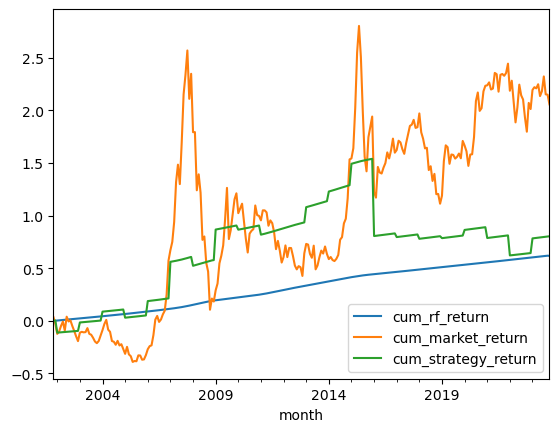

In [64]:
long_only[['cum_rf_return', 'cum_market_return', 'cum_strategy_return']].plot()

In [65]:
long_short['cum_rf_return'] = long_short['rf']
long_short.iloc[0, 5] -= 0.0024  # we buy rf at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_short['cum_rf_return'] = (1+long_short['cum_rf_return']).cumprod()
long_short['cum_rf_return'] -= 1
long_short.iloc[long_short.shape[0] - 1, 5] -= 0.0034  # we sell rf at the end of the period, so we need to minus the transaction cost

long_short['cum_market_return'] = long_short['market_return']
long_short.iloc[0, 6] -= 0.0024  # we buy market at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_short['cum_market_return'] = (1+long_short['cum_market_return']).cumprod()
long_short['cum_market_return'] -= 1
long_short.iloc[long_short.shape[0] - 1, 6] -= 0.0034  # we sell market at the end of the period, so we need to minus the transaction cost

long_short['if_January'] = long_short['month'].dt.month == 1
long_short['if_January'] = long_short['if_January'].astype(int)
long_short['cum_strategy_return'] = (long_short['long_short'] - 0.0058)* long_short['if_January'] + long_short['rf']*(1-long_short['if_January'])
long_short['cum_strategy_return'] = (1+long_short['cum_strategy_return']).cumprod()
long_short['cum_strategy_return'] -= 1

long_short.tail(5)

,long_short,month,rf,mkt_risk_premium,market_return,cum_rf_return,cum_market_return,if_January,cum_strategy_return
month,,,,,,,,,
2023-06,0.090231,2023-06,0.001231,0.01351,0.014741,0.613114,2.182657,0,0.411585
2023-07,0.082677,2023-07,0.001272,0.042817,0.044089,0.615165,2.322977,0,0.413380
2023-08,0.012464,2023-08,0.001272,-0.052422,-0.05115,0.617219,2.153006,0,0.415178
2023-09,-0.003622,2023-09,0.001231,-0.002334,-0.001103,0.619210,2.149527,0,0.416919
2023-10,-0.001843,2023-10,0.001272,-0.02938,-0.028108,0.617869,2.0576,0,0.418721


<Axes: xlabel='month'>

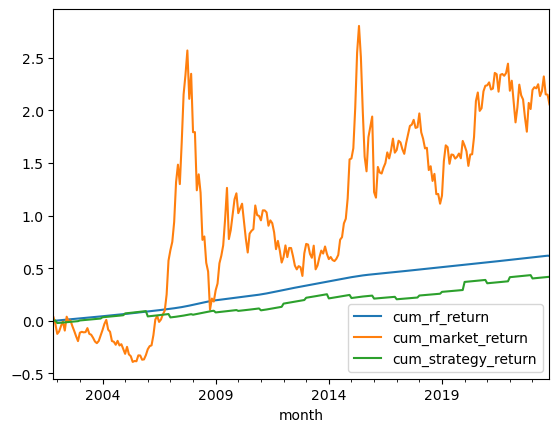

In [66]:
long_short[['cum_rf_return', 'cum_market_return', 'cum_strategy_return']].plot()

The picture above is the strategy with "investing based on our facotrs on January, and investing in risk-free assets in other months". 

now we will compare the return only in January.

In [67]:
long_only_january = long_only[long_only['if_January'] == 1]
long_only_january[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt']).to_excel(r'output/part2/January Anomaly long only January.xlsx')
long_only_january[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_only,rf,market_return
mean,0.019140,0.001867,-0.007016
std,0.117333,0.000609,0.086679
min,-0.283067,0.001272,-0.244120
max,0.292245,0.003447,0.099332
skew,-0.134217,0.954318,-1.182574
kurt,1.750594,0.619178,1.360515


In [68]:
long_short_january = long_short[long_short['if_January'] == 1]
long_short_january[['long_short', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt']).to_excel(r'output/part2/January Anomaly long short January.xlsx')
long_short_january[['long_short', 'rf', 'market_return']]

,long_short,rf,market_return
month,,,
2002-01,-0.018753,0.001893,-0.098488
2003-01,0.012497,0.001675,0.099332
2004-01,0.017617,0.001675,0.061221
2005-01,0.021992,0.001893,-0.061317
2006-01,-0.040220,0.001893,0.082959
2007-01,-0.024372,0.002110,0.062918
2008-01,0.000842,0.003447,-0.165756
2009-01,-0.008672,0.001893,0.090275
2010-01,-0.001220,0.001893,-0.085266


## 1.7 Backtesting on Reversal

In this section, we will backtesting the strategy only by sorting on reversal.

In [69]:
monthly_stock_return.head(20)

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,REV*JAN_loading,mkt_risk_premium*JAN_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1,new_ROE_tag,new_ROE_tag t - 1,rule,rule t - 1
13,000001,2001-11,-0.028240,0.001832,-0.030072,2.611293e+10,8.518143e+10,4.961824e+09,0.190014,0.044986,...,0.000908,-0.001129,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
14,000001,2001-12,-0.087183,0.001893,-0.089076,2.383632e+10,1.201270e+11,3.627669e+09,0.152191,0.110914,...,0.030145,0.075335,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
15,000001,2002-01,-0.140408,0.001893,-0.142301,2.048951e+10,1.201270e+11,3.627669e+09,0.177050,0.110914,...,0.032769,0.052732,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
16,000001,2002-02,-0.036087,0.001653,-0.037740,1.975009e+10,1.201270e+11,3.627669e+09,0.183679,0.110914,...,0.019253,0.061663,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
17,000001,2002-03,0.086700,0.001675,0.085025,2.146242e+10,1.106886e+11,3.811916e+09,0.177609,0.048257,...,0.021361,0.063582,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
18,000001,2002-04,0.042611,0.001621,0.040990,2.237695e+10,1.106886e+11,3.811916e+09,0.170350,0.048257,...,0.023331,0.063898,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
19,000001,2002-05,-0.029565,0.001675,-0.031240,2.171538e+10,1.106886e+11,3.811916e+09,0.175540,0.048257,...,0.023969,0.048019,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
20,000001,2002-06,0.344086,0.001621,0.342465,2.918733e+10,1.346890e+11,3.941856e+09,0.135054,0.079694,...,0.014192,0.039417,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
21,000001,2002-07,0.010633,0.001675,0.008958,2.920679e+10,1.346890e+11,3.941856e+09,0.134964,0.079694,...,0.006991,0.057028,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0
22,000001,2002-08,0.025983,0.001675,0.024308,2.996566e+10,1.346890e+11,3.941856e+09,0.131546,0.079694,...,0.006209,0.061456,1,1.0,0.0,0.0,1.0,1.0,10.01.0,10.01.0


In [70]:
tmp = monthly_stock_return.groupby(['month', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['monthly_stock_return'], weights=x['market_value']), include_groups=False).unstack()
long_only = tmp[0]
long_short = tmp[0] - tmp[9]

In [71]:
long_only = pd.DataFrame(long_only)
long_only.columns = ['long_only']
long_short = pd.DataFrame(long_short)
long_short.columns = ['long_short']

In [72]:
long_only['month'] = long_only.index
long_short['month'] = long_short.index

In [73]:
# merge rf and market return to long_only and long_short
long_only['rf'] = long_only['month'].map(rf_monthly.set_index('month')['monthly_rf'])
long_only['mkt_risk_premium'] = long_only['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
long_only['market_return'] = long_only['mkt_risk_premium'] + long_only['rf']

long_short['rf'] = long_short['month'].map(rf_monthly.set_index('month')['monthly_rf'])
long_short['mkt_risk_premium'] = long_short['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
long_short['market_return'] = long_short['mkt_risk_premium'] + long_short['rf']

In [74]:
long_only_jan = long_only[long_only['month'].dt.month == 1]
long_short_jan = long_short[long_short['month'].dt.month == 1]

In [75]:
long_only_jan[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt']).to_excel(r'output/part2/January anomaly Reversal long only January.xlsx')
long_short_jan[['long_short', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt']).to_excel(r'output/part2/January anomaly Reversal long short January.xlsx')

In [76]:
long_only_jan[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_only,rf,market_return
mean,0.014874,0.001867,-0.007016
std,0.122057,0.000609,0.086679
min,-0.269658,0.001272,-0.244120
max,0.300070,0.003447,0.099332
skew,-0.031202,0.954318,-1.182574
kurt,0.895195,0.619178,1.360515


In [77]:
long_short_jan[['long_short', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_short,rf,market_return
mean,0.017797,0.001867,-0.007016
std,0.071472,0.000609,0.086679
min,-0.112285,0.001272,-0.244120
max,0.207632,0.003447,0.099332
skew,0.962229,0.954318,-1.182574
kurt,1.476417,0.619178,1.360515


# Monday Anomaly

[here](https://www.investopedia.com/terms/m/mondayeffect.asp#:~:text=The%20Monday%20effect%20has%20been%20a%20mainstay%20anomaly,this%20negative%20return%20disappeared%20between%201987%20and%201998) is a short introduction to Monday Anomaly, which says "The Monday effect is sometimes known as the weekend effect, which describes the phenomenon that Monday returns are often significantly lower than the previous Friday's returns."

Also, you can refer to the paper [F Cross, 1973](papers/The%20Behavior%20of%20Stock%20Prices%20on%20Fridays%20and%20Mondays.pdf) for more information.

## 2.0 a simple view on market return

In [78]:
# get daily stock return data
daily_stock_return = pd.read_feather(r'temp/daily_stock_return.feather')
daily_stock_return = daily_stock_return[['Stkcd', 'Trddt','Dsmvtll', 'Dretnd']]
daily_stock_return['Dsmvtll'] = daily_stock_return['Dsmvtll'] * 1000
daily_stock_return.columns = ['Stkcd', 'date', 'market_value','daily_stock_return']
daily_stock_return.date = pd.to_datetime(daily_stock_return['date'])
daily_stock_return.head(10)

,Stkcd,date,market_value,daily_stock_return
0,000001,2000-01-04,2.838328e+10,0.048138
1,000001,2000-01-05,2.802636e+10,-0.012575
2,000001,2000-01-06,2.914369e+10,0.039867
3,000001,2000-01-07,3.032309e+10,0.040469
4,000001,2000-01-10,3.125420e+10,0.030706
5,000001,2000-01-11,2.948509e+10,-0.056604
6,000001,2000-01-12,2.830569e+10,-0.040000
7,000001,2000-01-13,2.815051e+10,-0.005482
8,000001,2000-01-14,2.774703e+10,-0.014333
9,000001,2000-01-17,2.805740e+10,0.011186


In [79]:
daily_stock_return.shape

(14357450, 4)

In [80]:
# get factors data
factor_data = pd.read_excel(r'source_data/5-Factor Model Index (Daily)/STK_MKT_FIVEFACDAY.xlsx')
factor_data = factor_data[
    ['MarkettypeID', 'TradingDate', 'Portfolios', 'RiskPremium2', 'SMB2', 'HML2', 'RMW2', 'CMA2']]
factor_data.columns = ['MarkettypeID', 'date', 'portfolios', 'mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = factor_data.iloc[2:, :]
factor_data = factor_data[factor_data['portfolios'] == 1]
factor_data = factor_data[
    factor_data['MarkettypeID'] == "P9706"]  # P9706: SSE-SZSE A share market (excluding STAR Market, ChiNext)
factor_data.reset_index(drop=True, inplace=True)  # reset the index to 0,1,2,...
factor_data.drop(columns=['portfolios', 'MarkettypeID'], inplace=True)
factor_data['date'] = pd.to_datetime(factor_data['date'])
factor_data.head(10)

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,mkt_risk_premium,SMB,HML,RMW,CMA
0,2000-01-04,0.030129,-0.004477,-0.004401,0.001593,0.002262
1,2000-01-05,0.00294,0.007498,0.002194,-0.008033,0.003908
2,2000-01-06,0.039874,-0.011148,-0.001401,0.011542,-0.007103
3,2000-01-07,0.036126,-0.003452,-0.000118,0.002772,-0.003219
4,2000-01-10,0.020103,0.002671,0.00007,-0.000712,-0.004836
5,2000-01-11,-0.042122,0.003841,-0.007314,-0.00019,0.004162
6,2000-01-12,-0.028083,0.004438,0.000552,-0.004317,0.000192
7,2000-01-13,-0.006706,-0.000024,0.00127,-0.000383,-0.001429
8,2000-01-14,-0.011077,0.000061,-0.005152,0.000878,-0.004687
9,2000-01-17,0.017037,-0.001774,-0.002193,0.006988,-0.005244


We will calculate some statistics of the market return of "all Days", "Monday only" and "Non-Monday" to check whether Monday anomaly exists.

In [81]:
# import and clean the risk-free rate data
rf = pd.read_excel('source_data/Risk-Free Rate/TRD_Nrrate.xlsx')  # load the risk-free rate data
rf = rf.iloc[2:, :]
rf = rf[['Clsdt', 'Nrrdaydt','Nrrdata']]
rf.columns = ['date', 'daily_rf','rf']
rf['date'] = pd.to_datetime(rf['date'])
rf['daily_rf'] = rf['daily_rf'] / 100  # change the unit of the risk-free rate to decimal
rf['rf'] = rf['rf'] / 100  # change the unit of the risk-free rate to decimal
rf['month'] = rf['date'].dt.to_period('M')
rf['date'] = pd.to_datetime(rf['date'])

# merge the risk-free rate data into daily_stock_return
daily_stock_return['rf'] = daily_stock_return['date'].map(rf.set_index('date')['rf'])
daily_stock_return['excess_return'] = daily_stock_return['daily_stock_return'] - daily_stock_return['rf']
daily_stock_return.head(10)

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Stkcd,date,market_value,daily_stock_return,rf,excess_return
0,000001,2000-01-04,2.838328e+10,0.048138,0.0225,0.025638
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104
6,000001,2000-01-12,2.830569e+10,-0.040000,0.0225,-0.0625
7,000001,2000-01-13,2.815051e+10,-0.005482,0.0225,-0.027982
8,000001,2000-01-14,2.774703e+10,-0.014333,0.0225,-0.036833
9,000001,2000-01-17,2.805740e+10,0.011186,0.0225,-0.011314


In [82]:
# add day kind: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday
daily_stock_return['day_kind'] = daily_stock_return['date'].dt.day_name()
daily_stock_return.head(10)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind
0,000001,2000-01-04,2.838328e+10,0.048138,0.0225,0.025638,Tuesday
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075,Wednesday
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367,Thursday
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969,Friday
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206,Monday
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104,Tuesday
6,000001,2000-01-12,2.830569e+10,-0.040000,0.0225,-0.0625,Wednesday
7,000001,2000-01-13,2.815051e+10,-0.005482,0.0225,-0.027982,Thursday
8,000001,2000-01-14,2.774703e+10,-0.014333,0.0225,-0.036833,Friday
9,000001,2000-01-17,2.805740e+10,0.011186,0.0225,-0.011314,Monday


In [83]:
return_stat = pd.DataFrame(index=['mean', 'median','std', 'min', 'max', '.01 quantile', '.25 quantile', '.5 quantile', '.75 quantile', '.99 quantile', 'skew', 'kurt'], columns=['all days', 'Monday only', 'Non-Monday'])

# calculate market return
tmp = daily_stock_return.groupby(['date'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False)

# calculate market return of Monday
tmp_monday = daily_stock_return[daily_stock_return['day_kind'] == 'Monday'].groupby(['date'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False)

# calculate market return of non-January
tmp_non_monday = daily_stock_return[daily_stock_return['day_kind'] != 'Monday'].groupby(['date'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False)

return_stat.iloc[:, 0] = [tmp.mean(), tmp.median(),tmp.std(), tmp.min(), tmp.max(), tmp.quantile(0.01), tmp.quantile(0.25), tmp.quantile(0.5), tmp.quantile(0.75), tmp.quantile(0.99), tmp.skew(), tmp.kurt()]
return_stat.iloc[:, 1] = [tmp_monday.mean(), tmp_monday.median(),tmp_monday.std(), tmp_monday.min(), tmp_monday.max(), tmp_monday.quantile(0.01), tmp_monday.quantile(0.25), tmp_monday.quantile(0.5), tmp_monday.quantile(0.75), tmp_monday.quantile(0.99), tmp_monday.skew(), tmp_monday.kurt()]
return_stat.iloc[:, 2] = [tmp_non_monday.mean(), tmp_non_monday.median(),tmp_non_monday.std(), tmp_non_monday.min(), tmp_non_monday.max(), tmp_non_monday.quantile(0.01), tmp_non_monday.quantile(0.25), tmp_non_monday.quantile(0.5), tmp_non_monday.quantile(0.75), tmp_non_monday.quantile(0.99), tmp_non_monday.skew(), tmp_non_monday.kurt()]
return_stat.to_excel('output/part2/Monday Anomaly return stat.xlsx')
return_stat

,all days,Monday only,Non-Monday
mean,-0.021122,-0.01998,-0.0214
median,-0.019527,-0.018096,-0.019794
std,0.018078,0.022797,0.016718
min,-0.120939,-0.114299,-0.120939
max,0.299033,0.299033,0.094925
.01 quantile,-0.07683,-0.092084,-0.073432
.25 quantile,-0.029726,-0.030141,-0.029687
.5 quantile,-0.019527,-0.018096,-0.019794
.75 quantile,-0.011408,-0.008403,-0.012174
.99 quantile,0.019279,0.029791,0.016364


## 2.1 construct momentum factor and reversal factor

from here untill 2.2.2, what we are doing is add all variables(such as total assets, ROE etc), all factor tags and factors to the daily_stock_return data, then we will run regression to check whether Monday anomaly exists. 

Because this process is very time-consuming, we will save the data to a feather file and load it when we need it. So, after the first time, you can select the cell here and run "run all above" to run all codes above, and then skip to 2.2.2 and run "run all below" command to run all codes below.

In [84]:
# construct momentum tag
# very time-consuming, 9min6s on i7-13700K
tmp = daily_stock_return.groupby(['Stkcd'])['daily_stock_return'].rolling(window=2).apply(lambda x: (1 + x).prod() - 1) # we just need to check the last day's return
tmp = tmp.reset_index()
daily_stock_return['momentum'] = (tmp['daily_stock_return'] + 1) / (daily_stock_return['daily_stock_return'] + 1) - 1
daily_stock_return.head(20)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind,momentum
0,000001,2000-01-04,2.838328e+10,0.048138,0.0225,0.025638,Tuesday,NaN
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075,Wednesday,0.048138
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367,Thursday,-0.012575
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969,Friday,0.039867
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206,Monday,0.040469
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104,Tuesday,0.030706
6,000001,2000-01-12,2.830569e+10,-0.040000,0.0225,-0.0625,Wednesday,-0.056604
7,000001,2000-01-13,2.815051e+10,-0.005482,0.0225,-0.027982,Thursday,-0.040000
8,000001,2000-01-14,2.774703e+10,-0.014333,0.0225,-0.036833,Friday,-0.005482
9,000001,2000-01-17,2.805740e+10,0.011186,0.0225,-0.011314,Monday,-0.014333


In [85]:
# construct reversal tag
tmp = daily_stock_return.groupby(['Stkcd'])['daily_stock_return'].shift(1)
daily_stock_return['reversal'] = tmp
daily_stock_return.head(20)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind,momentum,reversal
0,000001,2000-01-04,2.838328e+10,0.048138,0.0225,0.025638,Tuesday,NaN,NaN
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075,Wednesday,0.048138,0.048138
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367,Thursday,-0.012575,-0.012575
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969,Friday,0.039867,0.039867
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206,Monday,0.040469,0.040469
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104,Tuesday,0.030706,0.030706
6,000001,2000-01-12,2.830569e+10,-0.040000,0.0225,-0.0625,Wednesday,-0.056604,-0.056604
7,000001,2000-01-13,2.815051e+10,-0.005482,0.0225,-0.027982,Thursday,-0.040000,-0.040000
8,000001,2000-01-14,2.774703e+10,-0.014333,0.0225,-0.036833,Friday,-0.005482,-0.005482
9,000001,2000-01-17,2.805740e+10,0.011186,0.0225,-0.011314,Monday,-0.014333,-0.014333


In [86]:
daily_stock_return.dropna(inplace=True)
daily_stock_return.head(20)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind,momentum,reversal
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075,Wednesday,0.048138,0.048138
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367,Thursday,-0.012575,-0.012575
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969,Friday,0.039867,0.039867
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206,Monday,0.040469,0.040469
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104,Tuesday,0.030706,0.030706
6,000001,2000-01-12,2.830569e+10,-0.040000,0.0225,-0.0625,Wednesday,-0.056604,-0.056604
7,000001,2000-01-13,2.815051e+10,-0.005482,0.0225,-0.027982,Thursday,-0.040000,-0.040000
8,000001,2000-01-14,2.774703e+10,-0.014333,0.0225,-0.036833,Friday,-0.005482,-0.005482
9,000001,2000-01-17,2.805740e+10,0.011186,0.0225,-0.011314,Monday,-0.014333,-0.014333
10,000001,2000-01-18,2.745218e+10,-0.021571,0.0225,-0.044071,Tuesday,0.011186,0.011186


In [87]:
# construct momentum factor
daily_stock_return['momentum_tag'] = daily_stock_return.groupby(['date'])['momentum'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
daily_stock_return['momentum_tag'] = daily_stock_return['momentum_tag'].astype('category')
tmp = daily_stock_return.groupby(['date', 'momentum_tag'], observed=False).apply(lambda x: np.average(x['daily_stock_return'], weights=x['market_value']), include_groups=False).unstack()
tmp['momentum'] = tmp[9] - tmp[0]
factor_data = pd.merge(factor_data, tmp[['momentum']], left_on='date', right_index=True, how='left')
factor_data.dropna(inplace=True)
factor_data

,date,mkt_risk_premium,SMB,HML,RMW,CMA,momentum
1,2000-01-05,0.00294,0.007498,0.002194,-0.008033,0.003908,-0.034903
2,2000-01-06,0.039874,-0.011148,-0.001401,0.011542,-0.007103,-0.035007
3,2000-01-07,0.036126,-0.003452,-0.000118,0.002772,-0.003219,-0.037031
4,2000-01-10,0.020103,0.002671,0.00007,-0.000712,-0.004836,-0.069768
5,2000-01-11,-0.042122,0.003841,-0.007314,-0.00019,0.004162,-0.059016
...,...,...,...,...,...,...,...
5811,2023-12-25,0.002024,-0.008023,-0.001831,0.00626,-0.004438,-0.021981
5812,2023-12-26,-0.005553,-0.004072,0.004755,0.002202,-0.003095,-0.024053
5813,2023-12-27,0.006401,0.002276,0.002346,0.001196,0.001285,-0.021899
5814,2023-12-28,0.012819,0.000403,-0.015388,0.00784,-0.005481,-0.053514


In [88]:
# construct reversal factor
daily_stock_return['reversal_tag'] = daily_stock_return.groupby(['date'])['reversal'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
daily_stock_return['reversal_tag'] = daily_stock_return['reversal_tag'].astype('category')
tmp = daily_stock_return.groupby(['date', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['daily_stock_return'], weights=x['market_value']), include_groups=False).unstack()
tmp['reversal'] = tmp[9] - tmp[0]
factor_data = pd.merge(factor_data, tmp[['reversal']], left_on='date', right_index=True, how='left')
factor_data

,date,mkt_risk_premium,SMB,HML,RMW,CMA,momentum,reversal
1,2000-01-05,0.00294,0.007498,0.002194,-0.008033,0.003908,-0.034903,0.002091
2,2000-01-06,0.039874,-0.011148,-0.001401,0.011542,-0.007103,-0.035007,-0.000097
3,2000-01-07,0.036126,-0.003452,-0.000118,0.002772,-0.003219,-0.037031,0.000195
4,2000-01-10,0.020103,0.002671,0.00007,-0.000712,-0.004836,-0.069768,0.014896
5,2000-01-11,-0.042122,0.003841,-0.007314,-0.00019,0.004162,-0.059016,-0.005875
...,...,...,...,...,...,...,...,...
5811,2023-12-25,0.002024,-0.008023,-0.001831,0.00626,-0.004438,-0.021981,0.011395
5812,2023-12-26,-0.005553,-0.004072,0.004755,0.002202,-0.003095,-0.024053,0.009954
5813,2023-12-27,0.006401,0.002276,0.002346,0.001196,0.001285,-0.021899,-0.008832
5814,2023-12-28,0.012819,0.000403,-0.015388,0.00784,-0.005481,-0.053514,-0.025878


## 2.2 way 1: run regression for Monday and non-Monday group

Firstly, I will run the regression below with "all day", "Monday Only" and "Non-Monday" data to check whether Monday anomaly exists.
$$EXRET_{i,t} = \alpha + b_i MKTRP_t + c_i SMB_t + d_i HML_t +e_i RMW_t + g_i CMA_t + \epsilon_{i,t}$$

### 2.2.1 get sorted portfolio tag

we will sort all the stocks into 10 groups based on different indicators: momentum, reversal, market value, book-to-market ratio, size, and then calculate the average return of each group. Then we will run the regression above to check whether Monday anomaly exists.

In [89]:
# sort based on size
daily_stock_return['size_tag'] = daily_stock_return.groupby(['date'])['market_value'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))
daily_stock_return['size_tag'] = daily_stock_return['size_tag'].astype('category')
daily_stock_return.head(10)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind,momentum,reversal,momentum_tag,reversal_tag,size_tag
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075,Wednesday,0.048138,0.048138,8,8,9
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367,Thursday,-0.012575,-0.012575,6,1,9
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969,Friday,0.039867,0.039867,9,6,9
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206,Monday,0.040469,0.040469,8,6,9
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104,Tuesday,0.030706,0.030706,3,7,9
6,000001,2000-01-12,2.830569e+10,-0.040000,0.0225,-0.0625,Wednesday,-0.056604,-0.056604,0,2,9
7,000001,2000-01-13,2.815051e+10,-0.005482,0.0225,-0.027982,Thursday,-0.040000,-0.040000,1,2,9
8,000001,2000-01-14,2.774703e+10,-0.014333,0.0225,-0.036833,Friday,-0.005482,-0.005482,3,5,9
9,000001,2000-01-17,2.805740e+10,0.011186,0.0225,-0.011314,Monday,-0.014333,-0.014333,5,4,9
10,000001,2000-01-18,2.745218e+10,-0.021571,0.0225,-0.044071,Tuesday,0.011186,0.011186,5,4,9


In [90]:
balance_sheet['date'] = balance_sheet['month'].dt.to_timestamp().dt.to_period('D')
balance_sheet['date'] = balance_sheet['date'].dt.to_timestamp()
balance_sheet.head(20)

,Stkcd,month,total_assets,total_shareholders_equity,net_income,ROE,ROE_tag,assets_increasing_rate,INV_tag,date
0,000001,2000-06,4.973234e+10,3.078513e+09,NaN,0.000000,0,NaN,9,2000-06-01
1,000001,2000-12,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,2000-12-01
2,000001,2001-01,6.600617e+10,3.517551e+09,462975563.0,0.131619,2,-0.018167,3,2001-01-01
3,000001,2001-06,8.518143e+10,4.961824e+09,223211685.0,0.044986,2,0.290507,8,2001-06-01
4,000001,2001-12,1.201270e+11,3.627669e+09,402360428.0,0.110914,2,0.410249,9,2001-12-01
5,000001,2002-01,1.201270e+11,3.627669e+09,402360428.0,0.110914,2,0.000000,2,2002-01-01
6,000001,2002-03,1.106886e+11,3.811916e+09,183951144.0,0.048257,2,-0.078570,0,2002-03-01
7,000001,2002-06,1.346890e+11,3.941856e+09,314141342.0,0.079694,2,0.216829,9,2002-06-01
8,000001,2002-09,1.600220e+11,4.058194e+09,419642032.0,0.103406,2,0.188085,9,2002-09-01
9,000001,2002-12,1.661664e+11,3.768021e+09,432224930.0,0.114709,2,0.038397,6,2002-12-01


In [91]:
balance_sheet['Stkcd'] = balance_sheet['Stkcd'].astype('str')
balance_sheet.to_pickle('temp/bs.pickle')
daily_stock_return.to_pickle('temp/dst.pickle')
factor_data.to_pickle('temp/fd.pickle')

In [92]:
balance_sheet = pd.read_pickle('temp/bs.pickle')
daily_stock_return = pd.read_pickle('temp/dst.pickle')
factor_data = pd.read_pickle('temp/fd.pickle')

When we need to merge the balance sheet data into daily_stock_return, we need to fill the missing value of the balance sheet data. Because the 'date' in balance sheet is always the first day of the month, and it's totally natural that there's no transactions on that day because it's on the weekend.

In [93]:
daily_stock_return['month'] = daily_stock_return['date'].dt.to_period('M')
daily_stock_return.head(5)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind,momentum,reversal,momentum_tag,reversal_tag,size_tag,month
1,000001,2000-01-05,2.802636e+10,-0.012575,0.0225,-0.035075,Wednesday,0.048138,0.048138,8,8,9,2000-01
2,000001,2000-01-06,2.914369e+10,0.039867,0.0225,0.017367,Thursday,-0.012575,-0.012575,6,1,9,2000-01
3,000001,2000-01-07,3.032309e+10,0.040469,0.0225,0.017969,Friday,0.039867,0.039867,9,6,9,2000-01
4,000001,2000-01-10,3.125420e+10,0.030706,0.0225,0.008206,Monday,0.040469,0.040469,8,6,9,2000-01
5,000001,2000-01-11,2.948509e+10,-0.056604,0.0225,-0.079104,Tuesday,0.030706,0.030706,3,7,9,2000-01


In [94]:
daily_stock_return = daily_stock_return.merge(balance_sheet[['Stkcd', 'date','total_assets', 'total_shareholders_equity', 'net_income', 'ROE', 'ROE_tag', 'assets_increasing_rate', 'INV_tag', 'month']], left_on=['Stkcd', 'month'], right_on=['Stkcd', 'month'], how='left').ffill()
daily_stock_return.dropna(inplace=True)
daily_stock_return['total_assets'] = daily_stock_return['total_assets'].ffill().astype(
    np.float64)  # ffill means use the value of the last row to fill the missing value
daily_stock_return['total_shareholders_equity'] = daily_stock_return['total_shareholders_equity'].ffill().astype(
    np.float64)
daily_stock_return['BM ratio'] = daily_stock_return['total_shareholders_equity'] / daily_stock_return['market_value']
daily_stock_return['net_income'] = daily_stock_return['net_income'].ffill().astype(np.float64)
daily_stock_return['ROE'] = daily_stock_return['ROE'].ffill().astype(np.float64)
daily_stock_return['ROE_tag'] = daily_stock_return['ROE_tag'].ffill().astype(np.int64)
daily_stock_return['assets_increasing_rate'] = daily_stock_return['assets_increasing_rate'].ffill().astype(np.float64)
daily_stock_return['INV_tag'] = daily_stock_return['INV_tag'].ffill().astype(np.int64)
daily_stock_return['bm_tag'] = daily_stock_return.groupby(['date_x'])['BM ratio'].transform(lambda x:pd.qcut(x, 10, labels=False, duplicates='drop'))

daily_stock_return['bm_tag'] = daily_stock_return['bm_tag'].astype('category')
daily_stock_return['ROE_tag'] = daily_stock_return['ROE_tag'].astype('category')
daily_stock_return['INV_tag'] = daily_stock_return['INV_tag'].astype('category')

daily_stock_return.head(10)

/tmp/ipykernel_19732/973474224.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_stock_return = daily_stock_return.merge(balance_sheet[['Stkcd', 'date','total_assets', 'total_shareholders_equity', 'net_income', 'ROE', 'ROE_tag', 'assets_increasing_rate', 'INV_tag', 'month']], left_on=['Stkcd', 'month'], right_on=['Stkcd', 'month'], how='left').ffill()


,Stkcd,date_x,market_value,daily_stock_return,rf,excess_return,day_kind,momentum,reversal,momentum_tag,...,date_y,total_assets,total_shareholders_equity,net_income,ROE,ROE_tag,assets_increasing_rate,INV_tag,BM ratio,bm_tag
216,000001,2000-12-01,3.014079e+10,0.000000,0.0225,-0.022500,Friday,-0.001933,-0.001933,5,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.157225,3
217,000001,2000-12-04,3.014079e+10,0.000000,0.0225,-0.022500,Monday,0.000000,0.000000,5,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.157225,3
218,000001,2000-12-05,3.017970e+10,0.001291,0.0225,-0.021209,Tuesday,0.000000,0.000000,4,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.157022,3
219,000001,2000-12-06,2.992674e+10,-0.008382,0.0225,-0.030882,Wednesday,0.001291,0.001291,3,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.158349,3
220,000001,2000-12-07,2.977108e+10,-0.005202,0.0225,-0.027702,Thursday,-0.008382,-0.008382,3,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.159177,3
221,000001,2000-12-08,2.953758e+10,-0.007843,0.0225,-0.030343,Friday,-0.005202,-0.005202,4,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.160436,3
222,000001,2000-12-11,2.877871e+10,-0.025692,0.0225,-0.048192,Monday,-0.007843,-0.007843,2,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.164666,3
223,000001,2000-12-12,2.916787e+10,0.013523,0.0225,-0.008977,Tuesday,-0.025692,-0.025692,3,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.162469,3
224,000001,2000-12-13,2.887600e+10,-0.010007,0.0225,-0.032507,Wednesday,0.013523,0.013523,6,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.164111,3
225,000001,2000-12-14,2.910950e+10,0.008086,0.0225,-0.014414,Thursday,-0.010007,-0.010007,3,...,2000-12-01,6.722750e+10,4.738884e+09,506551785.0,0.106893,2,0.351786,8,0.162795,3


In [95]:
# daily_stock_return.drop(columns=['total_assets', 'total_shareholders_equity', 'net_income', 'ROE', 'ROE_tag', 'assets_increasing_rate', 'INV_tag'], inplace=True)
daily_stock_return.drop(columns=['date_y'], inplace=True)
tmp = list(daily_stock_return.columns)
daily_stock_return.columns = [tmp[0],] + ['date',] + tmp[2:]
daily_stock_return.tail(10)

,Stkcd,date,market_value,daily_stock_return,rf,excess_return,day_kind,momentum,reversal,momentum_tag,...,month,total_assets,total_shareholders_equity,net_income,ROE,ROE_tag,assets_increasing_rate,INV_tag,BM ratio,bm_tag
14346066,900957,2023-12-18,133667000.0,-0.030380,0.015,-0.045380,Monday,0.000000,0.000000,3,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.542368,9
14346067,900957,2023-12-19,135412000.0,0.013055,0.015,-0.001945,Tuesday,-0.030380,-0.030380,2,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.483832,9
14346068,900957,2023-12-20,135412000.0,0.000000,0.015,-0.015000,Wednesday,0.013055,0.013055,5,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.483832,9
14346069,900957,2023-12-21,136808000.0,0.010309,0.015,-0.004691,Thursday,0.000000,0.000000,5,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.438079,9
14346070,900957,2023-12-22,136110000.0,-0.005102,0.015,-0.020102,Friday,0.010309,0.010309,4,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.460838,9
14346071,900957,2023-12-25,134714000.0,-0.010256,0.015,-0.025256,Monday,-0.005102,-0.005102,4,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.507064,9
14346072,900957,2023-12-26,134016000.0,-0.005181,0.015,-0.020181,Tuesday,-0.010256,-0.010256,2,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.530539,9
14346073,900957,2023-12-27,136459000.0,0.018229,0.015,0.003229,Wednesday,-0.005181,-0.005181,5,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.449429,9
14346074,900957,2023-12-28,145882000.0,0.069054,0.015,0.054054,Thursday,0.018229,0.018229,8,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.162026,9
14346075,900957,2023-12-29,144137000.0,-0.011962,0.015,-0.026962,Friday,0.069054,0.069054,9,...,2023-12,1.064703e+09,6.071647e+08,4.349828e+08,0.716416,9,0.003732,4,4.212414,9


In [96]:
tmp

['Stkcd',
 'date_x',
 'market_value',
 'daily_stock_return',
 'rf',
 'excess_return',
 'day_kind',
 'momentum',
 'reversal',
 'momentum_tag',
 'reversal_tag',
 'size_tag',
 'month',
 'total_assets',
 'total_shareholders_equity',
 'net_income',
 'ROE',
 'ROE_tag',
 'assets_increasing_rate',
 'INV_tag',
 'BM ratio',
 'bm_tag']

In [97]:
# rearrange the columns for better view
daily_stock_return = daily_stock_return[['Stkcd', 'date', 'daily_stock_return','rf','excess_return', 'market_value','day_kind','total_assets', 'total_shareholders_equity', 'BM ratio','ROE', 'assets_increasing_rate', 'momentum', 'reversal', 'size_tag', 'ROE_tag', 'bm_tag', 'INV_tag', 'momentum_tag', 'reversal_tag']]
daily_stock_return.head(20)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,ROE,assets_increasing_rate,momentum,reversal,size_tag,ROE_tag,bm_tag,INV_tag,momentum_tag,reversal_tag
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,0.106893,0.351786,-0.001933,-0.001933,9,2,3,8,5,4
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,0.106893,0.351786,0.000000,0.000000,9,2,3,8,5,2
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,0.106893,0.351786,0.000000,0.000000,9,2,3,8,4,2
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,0.106893,0.351786,0.001291,0.001291,9,2,3,8,3,6
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,0.106893,0.351786,-0.008382,-0.008382,9,2,3,8,3,6
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,0.106893,0.351786,-0.005202,-0.005202,9,2,3,8,4,4
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,0.106893,0.351786,-0.007843,-0.007843,9,2,3,8,2,1
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,0.106893,0.351786,-0.025692,-0.025692,9,2,3,8,3,2
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,0.106893,0.351786,0.013523,0.013523,9,2,3,8,6,7
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,0.106893,0.351786,-0.010007,-0.010007,9,2,3,8,3,1


In [98]:
daily_stock_return.dtypes

Stkcd                                object
date                         datetime64[ns]
daily_stock_return                  float64
rf                                  float64
excess_return                       float64
market_value                        float64
day_kind                             object
total_assets                        float64
total_shareholders_equity           float64
BM ratio                            float64
ROE                                 float64
assets_increasing_rate              float64
momentum                            float64
reversal                            float64
size_tag                           category
ROE_tag                            category
bm_tag                             category
INV_tag                            category
momentum_tag                       category
reversal_tag                       category
dtype: object

In [99]:
daily_stock_return.to_feather('temp/tagged_daily_stock_return.feather')

### 2.2.2 calculate the average return of each group

In [100]:
# read feather file
daily_stock_return = pd.read_feather('temp/tagged_daily_stock_return.feather')
balance_sheet = pd.read_pickle('temp/bs.pickle')
factor_data = pd.read_pickle('temp/fd.pickle')

In [101]:
"""
    calculate the value-weighted average return of each group
"""

# size
vw_size_group2 = daily_stock_return.groupby(['date', 'size_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_size_group2 = vw_size_group2.reset_index()


# BM ratio
vw_bm_group2 = daily_stock_return.groupby(['date', 'bm_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_bm_group2 = vw_bm_group2.reset_index()


# ROE
vw_ROE_group2 = daily_stock_return.groupby(['date', 'ROE_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_ROE_group2 = vw_ROE_group2.reset_index()


# INV
vw_INV_group2 = daily_stock_return.groupby(['date', 'INV_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_INV_group2 = vw_INV_group2.reset_index()


# momentum
vw_momentum_group2 = daily_stock_return.groupby(['date', 'momentum_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_momentum_group2 = vw_momentum_group2.reset_index()


# reversal
vw_reversal_group2 = daily_stock_return.groupby(['date', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['market_value']), include_groups=False).unstack()
vw_reversal_group2 = vw_reversal_group2.reset_index()
vw_reversal_group2

reversal_tag,date,0,1,2,3,4,5,6,7,8,9
0,2000-01-05,-0.019713,-0.017370,-0.017088,-0.016851,-0.019197,-0.017406,-0.020207,-0.024865,-0.021928,-0.017622
1,2000-01-06,0.023147,0.023252,0.016212,0.012953,0.010630,0.008514,0.022352,0.014704,0.020053,0.023050
2,2000-01-07,0.016081,0.013040,0.011487,0.018940,0.015487,0.008300,0.017569,0.013162,0.015724,0.016276
3,2000-01-10,-0.002716,-0.004484,0.000033,-0.003130,-0.000403,-0.004484,-0.005756,0.000210,-0.010508,0.012180
4,2000-01-11,-0.047894,-0.063344,-0.061495,-0.064235,-0.066374,-0.065537,-0.064170,-0.072721,-0.069326,-0.053768
...,...,...,...,...,...,...,...,...,...,...,...
5810,2023-12-25,-0.019367,-0.013671,-0.016091,-0.016269,-0.014066,-0.016175,-0.014232,-0.013988,-0.011687,-0.007972
5811,2023-12-26,-0.026949,-0.026659,-0.027310,-0.025670,-0.024117,-0.023520,-0.021060,-0.023055,-0.023959,-0.016995
5812,2023-12-27,-0.002413,-0.005942,-0.006353,-0.006760,-0.007849,-0.010093,-0.010812,-0.009863,-0.011309,-0.011246
5813,2023-12-28,0.016342,0.022123,0.009658,0.002577,-0.004234,0.001396,-0.002251,-0.006191,-0.007825,-0.009536


In [102]:
"""
    calculate the equal-weighted average return of each group
"""

# size
ew_size_group2 = daily_stock_return.groupby(['date', 'size_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_size_group2 = ew_size_group2.reset_index()


# BM ratio
ew_bm_group2 = daily_stock_return.groupby(['date', 'bm_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_bm_group2 = ew_bm_group2.reset_index()


# ROE
ew_ROE_group2 = daily_stock_return.groupby(['date', 'ROE_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_ROE_group2 = ew_ROE_group2.reset_index()


# INV
ew_INV_group2 = daily_stock_return.groupby(['date', 'INV_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_INV_group2 = ew_INV_group2.reset_index()


# momentum
ew_momentum_group2 = daily_stock_return.groupby(['date', 'momentum_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_momentum_group2 = ew_momentum_group2.reset_index()


# reversal
ew_reversal_group2 = daily_stock_return.groupby(['date', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=None), include_groups=False).unstack()
ew_reversal_group2 = ew_reversal_group2.reset_index()
ew_reversal_group2

reversal_tag,date,0,1,2,3,4,5,6,7,8,9
0,2000-01-05,-0.019199,-0.018705,-0.019998,-0.018388,-0.018158,-0.017989,-0.017524,-0.024577,-0.019530,-0.013290
1,2000-01-06,0.013936,0.017963,0.016534,0.011341,0.007849,0.007641,0.014817,0.010317,0.011215,0.013944
2,2000-01-07,0.013560,0.012308,0.012502,0.019015,0.015985,0.011676,0.017519,0.014789,0.014988,0.016104
3,2000-01-10,-0.003728,-0.005716,-0.000487,-0.004981,-0.005286,-0.004273,-0.006785,-0.001750,-0.015331,0.009464
4,2000-01-11,-0.051817,-0.060773,-0.058651,-0.062537,-0.065872,-0.066049,-0.063674,-0.072124,-0.068760,-0.054153
...,...,...,...,...,...,...,...,...,...,...,...
5810,2023-12-25,-0.022921,-0.018552,-0.019109,-0.019035,-0.018362,-0.018272,-0.018188,-0.015977,-0.010496,0.005222
5811,2023-12-26,-0.026759,-0.026332,-0.028415,-0.026710,-0.028989,-0.029189,-0.029784,-0.031250,-0.028158,-0.008650
5812,2023-12-27,-0.005313,-0.004950,-0.004097,-0.004721,-0.006412,-0.006131,-0.008479,-0.008761,-0.011436,-0.018203
5813,2023-12-28,0.008901,0.012364,0.006634,0.006905,0.005093,0.005429,0.003966,0.001114,-0.002688,-0.007821


### 2.2.3 run the regression

$$EXRET_{i,t} = \alpha + b_i MKTRP_t + c_i SMB_t + d_i HML_t +e_i RMW_t + g_i CMA_t + \epsilon_{i,t}$$

In [103]:
def regress(data, factors):
    result = pd.DataFrame(columns=['D1', 'D10', 'D10-D1', 'D1(Monday only)', 'D10(Monday only)', 'D10-D1(Monday only)', 'D1(non-Monday only)', 'D10(non-Monday only)', 'D10-D1(non-Monday only)'], index=['alpha', 't-alpha'])
    
    # All months
    y = data[0].to_numpy()
    x = factors[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 0] = model.params[0]
    result.iloc[1, 0] = model.tvalues[0]
    
    y = data[9].to_numpy()
    x = factors[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 1] = model.params[0]
    result.iloc[1, 1] = model.tvalues[0]
    
    y = (data[9] - data[0]).to_numpy()
    x = factors[['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 2] = model.params[0]
    result.iloc[1, 2] = model.tvalues[0]
    
    # Monday only
    y = data[data['date'].dt.day_name() == 'Monday'][0].to_numpy()
    x = factors[factors['date'].dt.day_name() == 'Monday'][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 3] = model.params[0]
    result.iloc[1, 3] = model.tvalues[0]
    
    y = data[data['date'].dt.day_name() == 'Monday'][9].to_numpy()
    x = factors[factors['date'].dt.day_name() == 'Monday'][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 4] = model.params[0]
    result.iloc[1, 4] = model.tvalues[0]
    
    y = (data[data['date'].dt.day_name() == 'Monday'][9] - data[data['date'].dt.day_name() == 'Monday'][0]).to_numpy()
    x = factors[factors['date'].dt.day_name() == 'Monday'][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 5] = model.params[0]
    result.iloc[1, 5] = model.tvalues[0]
    
    # non-Monday only
    y = data[data['date'].dt.day_name() != 'Monday'][0].to_numpy()
    x = factors[factors['date'].dt.day_name() != 'Monday'][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 6] = model.params[0]
    result.iloc[1, 6] = model.tvalues[0]
    
    y = data[data['date'].dt.day_name() != 'Monday'][9].to_numpy()
    x = factors[factors['date'].dt.day_name() != 'Monday'][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 7] = model.params[0]
    result.iloc[1, 7] = model.tvalues[0]
    
    y = (data[data['date'].dt.day_name() != 'Monday'][9] - data[data['date'].dt.day_name() != 'Monday'][0]).to_numpy()
    x = factors[factors['date'].dt.day_name() != 'Monday'][['mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
    x = sm.add_constant(x)
    x = x.astype(float)
    model = sm.OLS(y, x, missing='drop').fit()
    result.iloc[0, 8] = model.params[0]
    result.iloc[1, 8] = model.tvalues[0]
    return result

In [104]:
result_vw_size_group2 = regress(vw_size_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_vw_bm_group2 = regress(vw_bm_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_vw_roe_group2 = regress(vw_ROE_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_vw_INV_group2 = regress(vw_INV_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_vw_momentum_group2 = regress(vw_momentum_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_vw_reversal_group2 = regress(vw_reversal_group2, factor_data[factor_data['date'] <= '2023-12-31'])

In [105]:
# concat all variables vertically
tmp = pd.concat([result_vw_size_group2, result_vw_bm_group2, result_vw_roe_group2, result_vw_INV_group2, result_vw_momentum_group2, result_vw_reversal_group2], axis=0)
tmp.index = ['size','t-size', 'bm','t-bm', 'ROE','t-roe', 'INV','t-INV', 'momentum', 't-momentum', 'reversal', 't-reversal']
tmp

,D1,D10,D10-D1,D1(Monday only),D10(Monday only),D10-D1(Monday only),D1(non-Monday only),D10(non-Monday only),D10-D1(non-Monday only)
size,-0.022967,-0.021829,0.001138,-0.02369,-0.021579,0.002111,-0.022765,-0.021861,0.000904
t-size,-158.64893,-189.263263,11.694741,-57.8357,-61.534404,8.519148,-152.570383,-192.216591,8.632334
bm,-0.020666,-0.022686,-0.00202,-0.020361,-0.022899,-0.002539,-0.020736,-0.022613,-0.001877
t-bm,-112.356204,-153.62784,-11.194303,-52.101117,-54.443641,-7.240742,-100.337812,-149.089085,-9.047597
ROE,-0.022096,-0.021286,0.00081,-0.021916,-0.021578,0.000338,-0.02211,-0.021189,0.000921
t-roe,-174.809279,-99.151206,4.183766,-57.850866,-54.230314,1.288592,-175.754458,-85.431375,3.967906
INV,-0.021942,-0.021705,0.000249,-0.021796,-0.021533,0.000246,-0.021966,-0.021724,0.000258
t-INV,-139.924151,-154.868775,1.8903,-54.824418,-52.240807,0.977911,-131.104406,-153.702606,1.696377
momentum,-0.000637,-0.036667,-0.03603,0.001223,-0.038067,-0.03929,-0.001121,-0.036267,-0.035145
t-momentum,-2.667795,-214.67905,-123.223851,2.31246,-78.047924,-60.950427,-4.203327,-209.239941,-107.777815


In [106]:
tmp.to_excel('output/part2/Monday Anomaly table 3 panel A.xlsx')

In [107]:
result_ew_size_group2 = regress(ew_size_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_ew_bm_group2 = regress(ew_bm_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_ew_roe_group2 = regress(ew_ROE_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_ew_INV_group2 = regress(ew_INV_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_ew_momentum_group2 = regress(ew_momentum_group2, factor_data[factor_data['date'] <= '2023-12-31'])
result_ew_reversal_group2 = regress(ew_reversal_group2, factor_data[factor_data['date'] <= '2023-12-31'])

tmp = pd.concat([result_ew_size_group2, result_ew_bm_group2, result_ew_roe_group2, result_ew_INV_group2, result_ew_momentum_group2, result_ew_reversal_group2], axis=0)
tmp.index = ['size','t-size', 'bm','t-bm', 'ROE','t-roe', 'INV','t-INV', 'momentum', 't-momentum', 'reversal', 't-reversal']
tmp

,D1,D10,D10-D1,D1(Monday only),D10(Monday only),D10-D1(Monday only),D1(non-Monday only),D10(non-Monday only),D10-D1(non-Monday only)
size,-0.022738,-0.021727,0.001011,-0.023688,-0.021272,0.002416,-0.022489,-0.021813,0.000675
t-size,-147.998982,-177.461589,8.825104,-54.380141,-57.738127,7.928163,-141.995785,-179.550017,5.564096
bm,-0.021185,-0.022761,-0.001576,-0.020996,-0.023231,-0.002235,-0.021216,-0.02263,-0.001414
t-bm,-161.341677,-152.738699,-12.919164,-57.942958,-54.332048,-7.29032,-155.63233,-148.293285,-10.693592
ROE,-0.022396,-0.021986,0.00041,-0.022455,-0.022325,0.00013,-0.022357,-0.021879,0.000478
t-roe,-176.868419,-163.473135,4.947802,-59.902198,-58.183977,0.641972,-175.864559,-158.685033,5.275196
INV,-0.022423,-0.021999,0.000444,-0.022331,-0.021827,0.000504,-0.022422,-0.022016,0.000427
t-INV,-181.581221,-167.442316,7.145246,-61.031311,-56.665785,3.331654,-181.353453,-165.96745,6.269275
momentum,0.002407,-0.038319,-0.040726,0.00372,-0.03945,-0.04317,0.002066,-0.037992,-0.040058
t-momentum,12.149804,-234.501332,-162.114695,7.531401,-85.334024,-74.372292,9.618719,-227.518408,-144.535524


In [108]:
tmp.to_excel('output/part2/Monday Anomaly table 3 panel B.xlsx')

the output above is just like table 3 in the paper, but the difference is that we use Fama-French 5-factor model while the paper used Fama-French 3-factor model

## 2.3 way 2: Fama-Macbeth Regression

Fama-Macbeth regression is a two-step procedure. You can refer this method here [Fama and Macbeth, 1973](papers/Fama-Macbeth-1973.pdf) 

In the first step, we run the cross-sectional regression:
$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{t}+\beta_{3,t}BM_{t}+\beta_{5,t}ROE_{t}+\beta_{7,t}INV_{t}+\beta_{9,t}MOM_{t}+\beta_{11,t}REV_{t}+\beta_{13,t}MRKRP_{t}+e_{i,t+1}$$

Then we can get the time-series average of the coefficients:
$$\bar{\beta_i}=\frac{1}{T}\sum_{t=1}^{T}\beta_{i,t}$$

Also, we can get  Standard errors, t-statistics, and p-values calculated using the Newey and West (1987) adjustment with six lags.

It should be pointed out that, the Fama-Macbeth regression introduction on Wikipedia [here](https://en.wikipedia.org/wiki/Fama%E2%80%93MacBeth_regression) and other websites are **wrong** !! And the module in Stata and Python are right. [Here](https://bbs.pinggu.org/thread-2321958-1-1.html) shows some debate over the two versions of Fama-Macbeth regression.

here we use the module powered by BYU, you can refer the module official website [here](https://fin-library.readthedocs.io/en/latest/contents.html)

In [109]:
factor_data.head(10)

,date,mkt_risk_premium,SMB,HML,RMW,CMA,momentum,reversal
1,2000-01-05,0.00294,0.007498,0.002194,-0.008033,0.003908,-0.034903,0.002091
2,2000-01-06,0.039874,-0.011148,-0.001401,0.011542,-0.007103,-0.035007,-0.000097
3,2000-01-07,0.036126,-0.003452,-0.000118,0.002772,-0.003219,-0.037031,0.000195
4,2000-01-10,0.020103,0.002671,0.00007,-0.000712,-0.004836,-0.069768,0.014896
5,2000-01-11,-0.042122,0.003841,-0.007314,-0.00019,0.004162,-0.059016,-0.005875
6,2000-01-12,-0.028083,0.004438,0.000552,-0.004317,0.000192,-0.052996,-0.004792
7,2000-01-13,-0.006706,-0.000024,0.00127,-0.000383,-0.001429,-0.030214,-0.000868
8,2000-01-14,-0.011077,0.000061,-0.005152,0.000878,-0.004687,-0.032042,0.008176
9,2000-01-17,0.017037,-0.001774,-0.002193,0.006988,-0.005244,-0.031637,0.009061
10,2000-01-18,-0.002155,0.001974,0.005003,0.005456,-0.001738,-0.050497,-0.011340


In [110]:
daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,ROE,assets_increasing_rate,momentum,reversal,size_tag,ROE_tag,bm_tag,INV_tag,momentum_tag,reversal_tag
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,0.106893,0.351786,-0.001933,-0.001933,9,2,3,8,5,4
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,0.106893,0.351786,0.000000,0.000000,9,2,3,8,5,2
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,0.106893,0.351786,0.000000,0.000000,9,2,3,8,4,2
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,0.106893,0.351786,0.001291,0.001291,9,2,3,8,3,6
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,0.106893,0.351786,-0.008382,-0.008382,9,2,3,8,3,6
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,0.106893,0.351786,-0.005202,-0.005202,9,2,3,8,4,4
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,0.106893,0.351786,-0.007843,-0.007843,9,2,3,8,2,1
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,0.106893,0.351786,-0.025692,-0.025692,9,2,3,8,3,2
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,0.106893,0.351786,0.013523,0.013523,9,2,3,8,6,7
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,0.106893,0.351786,-0.010007,-0.010007,9,2,3,8,3,1


In [111]:
daily_stock_return['mkt_risk_premium'] = daily_stock_return['date'].map(factor_data.set_index('date')['mkt_risk_premium'])
daily_stock_return['SMB'] = daily_stock_return['date'].map(factor_data.set_index('date')['SMB'])
daily_stock_return['HML'] = daily_stock_return['date'].map(factor_data.set_index('date')['HML'])
daily_stock_return['RMW'] = daily_stock_return['date'].map(factor_data.set_index('date')['RMW'])
daily_stock_return['CMA'] = daily_stock_return['date'].map(factor_data.set_index('date')['CMA'])
daily_stock_return['momentum'] = daily_stock_return['date'].map(factor_data.set_index('date')['momentum'])
daily_stock_return['reversal'] = daily_stock_return['date'].map(factor_data.set_index('date')['reversal'])
daily_stock_return.head(20)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,ROE_tag,bm_tag,INV_tag,momentum_tag,reversal_tag,mkt_risk_premium,SMB,HML,RMW,CMA
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,2,3,8,5,4,0.005524,0.003736,0.001555,0.000281,0.002486
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,2,3,8,5,2,0.005697,0.007903,0.004366,-0.001742,0.002348
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,2,3,8,4,2,-0.001301,-0.001535,-0.000925,0.000853,-0.001414
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,2,3,8,3,6,-0.008136,0.00134,0.001639,-0.001672,-0.000991
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,2,3,8,3,6,-0.000952,0.008251,0.007836,-0.008516,0.007454
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,2,3,8,4,4,0.0013,-0.002867,-0.003542,0.003476,-0.001538
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,2,3,8,2,1,-0.01099,0.002756,-0.003424,0.000547,0.005595
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,2,3,8,3,2,0.014349,0.000619,-0.004996,0.001748,-0.000508
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,2,3,8,6,7,-0.000085,0.002976,-0.000332,0.003468,-0.003489
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,2,3,8,3,1,-0.00209,0.002342,0.001028,0.000897,0.000624


In [112]:
daily_stock_return['SMB'] = daily_stock_return['SMB'].astype(float)
daily_stock_return['HML'] = daily_stock_return['HML'].astype(float)
daily_stock_return['RMW'] = daily_stock_return['RMW'].astype(float)
daily_stock_return['CMA'] = daily_stock_return['CMA'].astype(float)
daily_stock_return['mkt_risk_premium'] = daily_stock_return['mkt_risk_premium'].astype(float)

In [113]:
daily_stock_return[['date','excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium']].dtypes

date                datetime64[ns]
excess_return              float64
SMB                        float64
HML                        float64
RMW                        float64
CMA                        float64
momentum                   float64
reversal                   float64
mkt_risk_premium           float64
dtype: object

In [114]:
daily_stock_return['t+1_excess_return'] = daily_stock_return.groupby(['Stkcd'])['excess_return'].shift(-1)

In [115]:
daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,bm_tag,INV_tag,momentum_tag,reversal_tag,mkt_risk_premium,SMB,HML,RMW,CMA,t+1_excess_return
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,3,8,5,4,0.005524,0.003736,0.001555,0.000281,0.002486,-0.022500
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,3,8,5,2,0.005697,0.007903,0.004366,-0.001742,0.002348,-0.021209
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,3,8,4,2,-0.001301,-0.001535,-0.000925,0.000853,-0.001414,-0.030882
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,3,8,3,6,-0.008136,0.001340,0.001639,-0.001672,-0.000991,-0.027702
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,3,8,3,6,-0.000952,0.008251,0.007836,-0.008516,0.007454,-0.030343
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,3,8,4,4,0.001300,-0.002867,-0.003542,0.003476,-0.001538,-0.048192
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,3,8,2,1,-0.010990,0.002756,-0.003424,0.000547,0.005595,-0.008977
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,3,8,3,2,0.014349,0.000619,-0.004996,0.001748,-0.000508,-0.032507
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,3,8,6,7,-0.000085,0.002976,-0.000332,0.003468,-0.003489,-0.014414
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,3,8,3,1,-0.002090,0.002342,0.001028,0.000897,0.000624,-0.002447


In [116]:
a = daily_stock_return.groupby(['Stkcd'])
daily_stock_return['mkt_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['mkt_risk_premium'])/x['mkt_risk_premium'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['SMB_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['SMB'])/x['SMB'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['HML_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['HML'])/x['HML'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['RMW_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['RMW'])/x['RMW'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['CMA_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['CMA'])/x['CMA'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['momentum_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['momentum'])/x['momentum'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['reversal_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['reversal'])/x['reversal'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return.head(20)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,RMW,CMA,t+1_excess_return,mkt_loading,SMB_loading,HML_loading,RMW_loading,CMA_loading,momentum_loading,reversal_loading
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,0.000281,0.002486,-0.022500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,-0.001742,0.002348,-0.021209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,0.000853,-0.001414,-0.030882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,-0.001672,-0.000991,-0.027702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,-0.008516,0.007454,-0.030343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,0.003476,-0.001538,-0.048192,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,0.000547,0.005595,-0.008977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,0.001748,-0.000508,-0.032507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,0.003468,-0.003489,-0.014414,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,0.000897,0.000624,-0.002447,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
# https://fin-library.readthedocs.io/en/latest/contents.html
fm_all_days = fama_macbeth.fama_macbeth(daily_stock_return.loc[:,['date', 't+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading']].dropna(), 'date', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading'])
result_fm_all_days = fama_macbeth.fm_summary(fm_all_days, pvalues=True)

fm_Monday = fama_macbeth.fama_macbeth(daily_stock_return[daily_stock_return['day_kind'] == 'Monday'].loc[:,['date', 't+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading']].dropna(), 'date', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading'])
result_fm_Monday = fama_macbeth.fm_summary(fm_Monday, pvalues=True)

fm_non_Monday = fama_macbeth.fama_macbeth(daily_stock_return[daily_stock_return['day_kind'] != 'Monday'].loc[:,['date', 't+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading']].dropna(), 'date', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'mkt_loading'])
result_fm_non_Monday = fama_macbeth.fm_summary(fm_non_Monday, pvalues=True)

In [118]:
# # https://fin-library.readthedocs.io/en/latest/contents.html
# daily_stock_return.dropna(inplace=True)
# fm_all_days = fama_macbeth.fama_macbeth(daily_stock_return.loc[:,['date','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium']], 'date', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium'])
# result_fm_all_days = fama_macbeth.fm_summary(fm_all_days, pvalues=True)
# 
# fm_Monday = fama_macbeth.fama_macbeth(daily_stock_return[daily_stock_return['day_kind'] == 'Monday'].loc[:,['date','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium']], 'date', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium'])
# result_fm_Monday = fama_macbeth.fm_summary(fm_Monday, pvalues=True)
# 
# fm_non_Monday = fama_macbeth.fama_macbeth(daily_stock_return[daily_stock_return['day_kind'] != 'Monday'].loc[:,['date','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium']], 'date', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium'])
# result_fm_non_Monday = fama_macbeth.fm_summary(fm_non_Monday, pvalues=True)

In [119]:
pd.concat([result_fm_all_days, result_fm_Monday, result_fm_non_Monday], axis=1)

,mean,std_error,tstat,pval,mean,std_error,tstat,pval,mean,std_error,tstat,pval
intercept,-0.022838,0.000218,-104.618451,0.000000e+00,-0.022812,0.000482,-47.365441,2.741921e-271,-0.022844,0.000245,-93.301607,0.000000e+00
SMB_loading,0.000148,0.000064,2.321136,2.031401e-02,0.000441,0.000147,3.012122,2.651631e-03,0.000077,0.000071,1.083471,2.786554e-01
HML_loading,-0.000166,0.000050,-3.308173,9.447866e-04,-0.000173,0.000117,-1.482564,1.384674e-01,-0.000165,0.000056,-2.957166,3.120389e-03
RMW_loading,0.000024,0.000055,0.431625,6.660301e-01,-0.000038,0.000115,-0.336006,7.369280e-01,0.000039,0.000062,0.624455,5.323591e-01
CMA_loading,0.000041,0.000035,1.172849,2.409044e-01,-0.000082,0.000078,-1.055912,2.912327e-01,0.000072,0.000040,1.810208,7.032793e-02
mkt_loading,0.000965,0.000106,9.136932,8.712336e-20,0.001190,0.000233,5.107963,3.816221e-07,0.000910,0.000118,7.683413,1.875983e-14


In [120]:
result_fm_all_days.to_excel(r'output/part2/Monday Anomaly Fama-Macbeth all days.xlsx')
result_fm_Monday.to_excel(r'output/part2/Monday Anomaly Fama-Macbeth Monday only.xlsx')
result_fm_non_Monday.to_excel(r'output/part2/Monday Anomaly Fama-Macbeth non-Monday only.xlsx')

## 2.4 way 3: Fama-Macbeth regression with time-fixed effects

$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{i,t}+\beta_{2,t}SIZE_{i,t}*Monday_{i,t+1}+\beta_{3,t}BM_{i,t}+\beta_{4,t}BM_{i,t}*Monday_{i,t+1}+\beta_{5,t}ROE_{i,t}+\beta_{6,t}ROE_{i,t}*Monday_{i,t+1}+\beta_{7,t}INV_{i,t}+\\ \beta_{8,t}INV_{i,t}*Monday_{i,t+1}+\beta_{9,t}MOM_{i,t}+\beta_{10, t}MOM_{i,t}*Monday_{i,t+1}+\beta_{11,t}REV_{i,t}+\beta_{12,t}REV_{i,t}*Monday_{i,t+1}+e_{i,t+1}$$



the Monday variable is a dummy variable, which is 1 if the day kind is Monday, otherwise 0.

In [121]:
daily_stock_return['Monday'] = daily_stock_return['day_kind'] == 'Monday'
daily_stock_return['Monday'] = daily_stock_return['Monday'].astype(int)
daily_stock_return['Monday t+1'] = daily_stock_return.groupby(['Stkcd'])['Monday'].shift(-1)
daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,t+1_excess_return,mkt_loading,SMB_loading,HML_loading,RMW_loading,CMA_loading,momentum_loading,reversal_loading,Monday,Monday t+1
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,-0.022500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,-0.021209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,-0.030882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,-0.027702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,-0.030343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,-0.048192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,-0.008977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,-0.032507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,-0.014414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,-0.002447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


In [122]:
daily_stock_return['size*Monday'] = daily_stock_return['SMB']*daily_stock_return['Monday t+1']
daily_stock_return['BM*Monday'] = daily_stock_return['HML']*daily_stock_return['Monday t+1']
daily_stock_return['ROE*Monday'] = daily_stock_return['ROE']*daily_stock_return['Monday t+1']
daily_stock_return['INV*Monday'] = daily_stock_return['assets_increasing_rate']*daily_stock_return['Monday t+1']
daily_stock_return['MOM*Monday'] = daily_stock_return['momentum']*daily_stock_return['Monday t+1']
daily_stock_return['REV*Monday'] = daily_stock_return['reversal']*daily_stock_return['Monday t+1']
daily_stock_return['mkt_risk_premium*Monday'] = daily_stock_return['mkt_risk_premium']*daily_stock_return['Monday t+1']

In [123]:
a = daily_stock_return.groupby(['Stkcd'])
daily_stock_return['size*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['size*Monday'])/x['size*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['BM*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['BM*Monday'])/x['BM*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['ROE*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['ROE*Monday'])/x['ROE*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['INV*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['INV*Monday'])/x['INV*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['MOM*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['MOM*Monday'])/x['MOM*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['REV*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['REV*Monday'])/x['REV*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return['mkt_risk_premium*Monday_loading'] = a.apply(lambda x: x['excess_return'].rolling(12).cov(x['mkt_risk_premium*Monday'])/x['mkt_risk_premium*Monday'].rolling(12).var(), include_groups=False).reset_index(level=0, drop=True)
daily_stock_return.head(20)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,MOM*Monday,REV*Monday,mkt_risk_premium*Monday,size*Monday_loading,BM*Monday_loading,ROE*Monday_loading,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,-0.011424,0.006565,0.005524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,-0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,-0.017279,-0.016950,0.001300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,-0.000000,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
fe_fm_all_days = fama_macbeth.fama_macbeth(daily_stock_return.loc[:,['date','t+1_excess_return', 'SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'momentum_loading', 'reversal_loading', 'mkt_loading', 'size*Monday_loading', 'BM*Monday_loading', 'ROE*Monday_loading', 'INV*Monday_loading', 'MOM*Monday_loading', 'REV*Monday_loading', 'mkt_risk_premium*Monday_loading']].dropna(), 'date', 't+1_excess_return', ['SMB_loading', 'HML_loading', 'RMW_loading', 'CMA_loading', 'momentum_loading', 'reversal_loading', 'mkt_loading', 'size*Monday_loading', 'BM*Monday_loading', 'ROE*Monday_loading', 'INV*Monday_loading', 'MOM*Monday_loading', 'REV*Monday_loading', 'mkt_risk_premium*Monday_loading'])
result_fe_fm_all_days = fama_macbeth.fm_summary(fe_fm_all_days, pvalues=True)
result_fe_fm_all_days

,mean,std_error,tstat,pval
intercept,-0.022732,0.000222,-102.584965,0.000000
SMB_loading,0.000280,0.000083,3.363827,0.000774
HML_loading,-0.000060,0.000067,-0.890953,0.372991
RMW_loading,-0.000013,0.000081,-0.166020,0.868147
CMA_loading,0.000007,0.000054,0.137801,0.890403
momentum_loading,0.000222,0.000439,0.506704,0.612382
reversal_loading,-0.000321,0.000109,-2.939225,0.003303
mkt_loading,0.000488,0.000147,3.325971,0.000887
size*Monday_loading,-0.000037,0.000130,-0.283013,0.777177
BM*Monday_loading,0.000013,0.000093,0.135435,0.892273


In [125]:
# fe_fm_all_days = fama_macbeth.fama_macbeth(daily_stock_return.loc[:,['date','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'MOM*Monday', 'REV*Monday', 'mkt_risk_premium*Monday']].dropna(), 'date', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'MOM*Monday', 'REV*Monday', 'mkt_risk_premium*Monday'])
# fe_fm_Monday = fama_macbeth.fama_macbeth(daily_stock_return[daily_stock_return['day_kind'] == 'Monday'].loc[:,['date','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'MOM*Monday', 'REV*Monday', 'mkt_risk_premium*Monday']], 'date', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'MOM*Monday', 'REV*Monday', 'mkt_risk_premium*Monday'])
# fe_fm_non_Monday = fama_macbeth.fama_macbeth(daily_stock_return[daily_stock_return['day_kind'] != 'Monday'].loc[:,['date','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'MOM*Monday', 'REV*Monday', 'mkt_risk_premium*Monday']].dropna(), 'date', 't+1_excess_return', ['SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'MOM*Monday', 'REV*Monday', 'mkt_risk_premium*Monday'])
# 
# result_fe_fm_all_days = fama_macbeth.fm_summary(fe_fm_all_days, pvalues=True)
# result_fe_fm_Monday = fama_macbeth.fm_summary(fe_fm_Monday, pvalues=True)
# result_fe_fm_non_Monday = fama_macbeth.fm_summary(fe_fm_non_Monday, pvalues=True)
# result_fe_fm_all_days

In [126]:
result_fe_fm_all_days.to_excel(r'output/part2/Monday Anomaly Fama-Macbeth with time-fixed effects all days.xlsx')
# result_fe_fm_Monday.to_excel(r'output/part2/Monday Anomaly Fama-Macbeth with time-fixed effects Monday only.xlsx')
# result_fe_fm_non_Monday.to_excel(r'output/part2/Monday Anomaly Fama-Macbeth with time-fixed effects non-Monday only.xlsx')

## 2.5 way 4: panel regression

the regression model is the same in 1.4, but in this section we run a panel regression instead of Fama-Macbeth Regression.

$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{i,t}+\beta_{2,t}SIZE_{i,t}*Monday_{i,t+1}+\beta_{3,t}BM_{i,t}+\beta_{4,t}BM_{i,t}*Monday_{i,t+1}+\beta_{5,t}ROE_{i,t}+\beta_{6,t}ROE_{i,t}*Monday_{i,t+1}+\beta_{7,t}INV_{i,t}+\\ \beta_{8,t}INV_{i,t}*Monday_{i,t+1}+\beta_{9,t}MOM_{i,t}+\beta_{10, t}MOM_{i,t}*Monday_{i,t+1}+\beta_{11,t}REV_{i,t}+\beta_{12,t}REV_{i,t}*Monday_{i,t+1}+e_{i,t+1}$$

In [127]:
daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,MOM*Monday,REV*Monday,mkt_risk_premium*Monday,size*Monday_loading,BM*Monday_loading,ROE*Monday_loading,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,-0.011424,0.006565,0.005524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,-0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,-0.017279,-0.016950,0.001300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,-0.000000,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
def simple_regress(y: np.array, x: pd.DataFrame):
    x = sm.add_constant(x)
    x = x.astype(float)
    y = y.astype(float)
    model = sm.OLS(y, x, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':6})
    return model

panel_reg = simple_regress(daily_stock_return['t+1_excess_return'].to_numpy(), daily_stock_return[['SMB', 'HML', 'RMW', 'CMA', 'mkt_risk_premium', 'size*Monday', 'BM*Monday', 'ROE*Monday', 'INV*Monday', 'mkt_risk_premium*Monday']])

In [129]:
with open(r'output/part2/Monday Anomaly panel regression summary.html', 'w') as f:
    f.write(panel_reg.summary().as_html())
panel_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5492.
Date:                Tue, 18 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:08:02   Log-Likelihood:             2.8207e+07
No. Observations:            14340172   AIC:                        -5.641e+07
Df Residuals:                14340161   BIC:                        -5.641e+07
Df Model:                          10                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0198   1.05e-05  -1888.766      0.000      -0.020      -0.020
SMB                        -0.0469      0.002    -20.301      0.000      -0.051      -0.042
HML                        -0.0870      0.002    -37.724      0.000      -0.092      -0.083
RMW                        -0.1290      0.003    -43.100      0.000      -0.135      -0.123
CMA                        -0.2583      0.003    -74.989      0.000      -0.265      -0.252
mkt_risk_premium            0.0146      0.001     17.537      0.000       0.013       0.016
size*Monday                 0.4052      0.004     98.500      0.000       0.397       0.413
BM*Monday                  -0.1054      0.005    -21.138      0.000      -0.115      -0.096
ROE*Monday               8.785e-08   4.99e-07      0.176      0.860   -8.89e-07    1.07e-06
INV*Monday              -1.165e-05   6.26e-06     -1.861      0.063   -2.39e-05    6.22e-07
mkt_risk_premium*Monday     0.2521      0.002    114.172      0.000       0.248       0.256
===============================================================================
Omnibus:                 50742369.272   Durbin-Watson:                    1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   617822153652869.875
Skew:                          68.579   Prob(JB):                          0.00
Kurtosis:                   32158.571   Cond. No.                      8.79e+03
===============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 8.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [130]:
with open(r'output/part2/Monday Anomaly panel regression summary2.html', 'w') as f:
    f.write(panel_reg.summary2().as_html())
panel_reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:               OLS               Adj. R-squared:      0.006         
Dependent Variable:  y                 AIC:                 -56414597.0692
Date:                2024-06-18 15:08  BIC:                 -56414437.8049
No. Observations:    14340172          Log-Likelihood:      2.8207e+07    
Df Model:            10                F-statistic:         5492.         
Df Residuals:        14340161          Prob (F-statistic):  0.00          
R-squared:           0.006             Scale:               0.0011455     
--------------------------------------------------------------------------
                         Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                   -0.0198   0.0000 -1888.7661 0.0000 -0.0198 -0.0197
SMB                     -0.0469   0.0023   -20.3007 0.0000 -0.0514 -0.0424
HML                     -0.0870   0.0023   -37.7241 0.0000 -0.0916 -0.0825
RMW                     -0.1290   0.0030   -43.1001 0.0000 -0.1349 -0.1231
CMA                     -0.2583   0.0034   -74.9893 0.0000 -0.2650 -0.2515
mkt_risk_premium         0.0146   0.0008    17.5371 0.0000  0.0130  0.0163
size*Monday              0.4052   0.0041    98.5000 0.0000  0.3972  0.4133
BM*Monday               -0.1054   0.0050   -21.1381 0.0000 -0.1151 -0.0956
ROE*Monday               0.0000   0.0000     0.1762 0.8601 -0.0000  0.0000
INV*Monday              -0.0000   0.0000    -1.8606 0.0628 -0.0000  0.0000
mkt_risk_premium*Monday  0.2521   0.0022   114.1716 0.0000  0.2477  0.2564
--------------------------------------------------------------------------
Omnibus:          50742369.272    Durbin-Watson:       1.832              
Prob(Omnibus):    0.000           Jarque-Bera (JB):    617822153652869.875
Skew:             68.579          Prob(JB):            0.000              
Kurtosis:         32158.571       Condition No.:       8790               
==========================================================================
Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust
(HAC) using 6 lags and without small sample correction
[2] The condition number is large, 8.79e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

## 2.6 Backtesting on factors

take all the results above into consideration, we can construct a trading strategy to take advantage of the January anomaly. 

The trading strategy is as follows:
1. Rank the stocks based on the size, BM ratio, using bivariate Dependent-Sort, i.e. sort the stocks firstly based on size, then in each group based on BM ratio. This ranking method is similar to Bivariate Dependent-Sort in Fama and French (1992).
2. Construct the portfolio according to the ranking, that is, to buy the stocks with the highest size and lowest BM ratio jointly and short stocks with lowest size and highest BM ratio.
3. Hold the portfolio for one day(Monday).
4. Repeat the above steps.

It should be pointed out that, in China, it is difficult to short stocks, especially for personal traders,so we will backtest the strategy with adn without shorting stocks respectively. Also, for different strategies, i.e. strategies with using January Anomaly, with stock market index and with risk-free assets, we have different trading frequencies, so we need to take the transaction costs into consideration. 

The calculation of the transaction costs is as follows, according to the website [here](https://finance.sina.com.cn/roll/2022-04-28/doc-ikqciyzk6371549.shtml):
1. Each buy order will produce commission fee of 0.002% and transfer fee of 1 yuan of each 1000 shares. It should be noted that, the minimum commision fee is 5 yuan and for transfer fee, less than 1000 shares are charged at 1 yuan. For simplicity, we assume the total rate of commission fee and transfer fee is 0.0024%
2. Each sell order will produce commision fee of 0.002% and transfer fee of 1 yuan of each 1000 shares. And sell order will have another 0.001% of stamp duty.
3. For simplicity, we assume that there's no tax, because it is really complex.


In [131]:
daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,MOM*Monday,REV*Monday,mkt_risk_premium*Monday,size*Monday_loading,BM*Monday_loading,ROE*Monday_loading,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,-0.011424,0.006565,0.005524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,-0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,-0.017279,-0.016950,0.001300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,-0.000000,-0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
def two_division(x):
    return np.where(x > np.quantile(x, 0.5), 1, 0)

daily_stock_return['new_size_tag'] = daily_stock_return.groupby(['date'], observed=False)['market_value'].transform(two_division)
daily_stock_return['new_size_tag t - 1'] = daily_stock_return.groupby(['Stkcd'], observed=False)['new_size_tag'].shift(1)
daily_stock_return['new_size_tag t - 1'] = daily_stock_return['new_size_tag t - 1'].astype('category')

daily_stock_return['new_bm_tag'] = daily_stock_return.groupby(['date', 'new_size_tag t - 1'], observed=False)['BM ratio'].transform(two_division)
daily_stock_return['new_bm_tag t - 1'] = daily_stock_return.groupby(['Stkcd'], observed=False)['new_bm_tag'].shift(1)
daily_stock_return['new_bm_tag t - 1'] = daily_stock_return['new_bm_tag t - 1'].astype('category')

daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,BM*Monday_loading,ROE*Monday_loading,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1
216,000001,2000-12-01,0.000000,0.0225,-0.022500,3.014079e+10,Friday,6.722750e+10,4.738884e+09,0.157225,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
217,000001,2000-12-04,0.000000,0.0225,-0.022500,3.014079e+10,Monday,6.722750e+10,4.738884e+09,0.157225,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,NaN
218,000001,2000-12-05,0.001291,0.0225,-0.021209,3.017970e+10,Tuesday,6.722750e+10,4.738884e+09,0.157022,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
219,000001,2000-12-06,-0.008382,0.0225,-0.030882,2.992674e+10,Wednesday,6.722750e+10,4.738884e+09,0.158349,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
220,000001,2000-12-07,-0.005202,0.0225,-0.027702,2.977108e+10,Thursday,6.722750e+10,4.738884e+09,0.159177,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
221,000001,2000-12-08,-0.007843,0.0225,-0.030343,2.953758e+10,Friday,6.722750e+10,4.738884e+09,0.160436,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
222,000001,2000-12-11,-0.025692,0.0225,-0.048192,2.877871e+10,Monday,6.722750e+10,4.738884e+09,0.164666,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
223,000001,2000-12-12,0.013523,0.0225,-0.008977,2.916787e+10,Tuesday,6.722750e+10,4.738884e+09,0.162469,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
224,000001,2000-12-13,-0.010007,0.0225,-0.032507,2.887600e+10,Wednesday,6.722750e+10,4.738884e+09,0.164111,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0
225,000001,2000-12-14,0.008086,0.0225,-0.014414,2.910950e+10,Thursday,6.722750e+10,4.738884e+09,0.162795,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,0.0


In [133]:
daily_stock_return['rule'] = daily_stock_return['new_size_tag'].astype(str) + daily_stock_return['new_bm_tag'].astype(str)
daily_stock_return['rule t - 1'] = daily_stock_return.groupby(['Stkcd'], observed=False)['rule'].shift(1)
daily_stock_return['rule t - 1'] = daily_stock_return['rule t - 1'].astype('category')
daily_stock_return.dropna(inplace=True)
daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1,rule,rule t - 1
227,000001,2000-12-18,0.000655,0.0225,-0.021845,2.971270e+10,Monday,6.722750e+10,4.738884e+09,0.159490,...,0.019696,-0.488649,0.295069,-1.900877,1,1.0,0.0,0.0,10.0,10.0
228,000001,2000-12-19,-0.020956,0.0225,-0.043456,2.909004e+10,Tuesday,6.722750e+10,4.738884e+09,0.162904,...,0.030625,-0.630968,0.212186,-4.833115,1,1.0,0.0,0.0,10.0,10.0
229,000001,2000-12-20,-0.006020,0.0225,-0.028520,2.891492e+10,Wednesday,6.722750e+10,4.738884e+09,0.163891,...,0.032336,-0.664924,0.177225,-4.906533,1,1.0,0.0,0.0,10.0,10.0
230,000001,2000-12-21,-0.002692,0.0225,-0.025192,2.883708e+10,Thursday,6.722750e+10,4.738884e+09,0.164333,...,0.033468,-0.687391,0.154094,-4.955109,1,1.0,0.0,0.0,10.0,10.0
231,000001,2000-12-22,-0.011471,0.0225,-0.033971,2.850629e+10,Friday,6.722750e+10,4.738884e+09,0.166240,...,0.015957,-0.330621,-0.081940,-3.504572,1,1.0,0.0,0.0,10.0,10.0
232,000001,2000-12-25,-0.017747,0.0225,-0.040247,2.800038e+10,Monday,6.722750e+10,4.738884e+09,0.169244,...,0.019920,-0.409046,-0.110136,-3.487403,1,1.0,0.0,0.0,10.0,10.0
233,000001,2000-12-26,0.000695,0.0225,-0.021805,2.801984e+10,Tuesday,6.722750e+10,4.738884e+09,0.169126,...,0.029298,-0.580894,-1.295529,-3.528409,1,1.0,0.0,0.0,10.0,10.0
234,000001,2000-12-27,-0.001389,0.0225,-0.023889,2.798092e+10,Wednesday,6.722750e+10,4.738884e+09,0.169361,...,0.022389,-0.445933,-1.504522,-3.501076,1,1.0,0.0,0.0,10.0,10.0
235,000001,2000-12-28,-0.001391,0.0225,-0.023891,2.794201e+10,Thursday,6.722750e+10,4.738884e+09,0.169597,...,0.026629,-0.528754,-1.376270,-3.517849,1,1.0,0.0,0.0,10.0,10.0
236,000001,2000-12-29,0.011142,0.0225,-0.011358,2.825334e+10,Friday,6.722750e+10,4.738884e+09,0.167728,...,0.020617,-0.411308,-1.558140,-3.494063,1,1.0,0.0,0.0,10.0,10.0


In [134]:
# daily_stock_return.to_feather('temp/before2.6_daily_stock_return.feather')
daily_stock_return = pd.read_feather('temp/before2.6_daily_stock_return.feather')

In [135]:
map_df = pd.DataFrame({"A":['10.0','11.0','00.0','01.0'],"B":['1','2','3','4']})
daily_stock_return['rule t - 1'] = daily_stock_return['rule t - 1'].astype(str)
# use map_df to convert the rule t - 1 to the corresponding rule
daily_stock_return['rule t - 1'] = daily_stock_return['rule t - 1'].astype(str)
daily_stock_return['rule t - 1'] = daily_stock_return['rule t - 1'].map(map_df.set_index('A')['B'])

# tmp = daily_stock_return.groupby(['date', 'rule t - 1'], observed=False).apply(lambda x: np.average(x['daily_stock_return'], weights=x['market_value']), include_groups=False).unstack() very very time-consuming, I can't wait it to finish
# so I transform the code into the GPU version
cudf.cuda.select_device(0)
cudf_daily_stock_return = cudf.DataFrame.from_pandas(daily_stock_return)
cudf_daily_stock_return.shape

(12283347, 55)

In [136]:
cudf_daily_stock_return.head(10)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1,rule,rule t - 1
227,000001,2000-12-18,0.000655,0.0225,-0.021845,2.971270e+10,Monday,6.722750e+10,4.738884e+09,0.159490,...,0.019696,-0.488649,0.295069,-1.900877,1,1.0,0.0,0.0,10.0,1
228,000001,2000-12-19,-0.020956,0.0225,-0.043456,2.909004e+10,Tuesday,6.722750e+10,4.738884e+09,0.162904,...,0.030625,-0.630968,0.212186,-4.833115,1,1.0,0.0,0.0,10.0,1
229,000001,2000-12-20,-0.006020,0.0225,-0.028520,2.891492e+10,Wednesday,6.722750e+10,4.738884e+09,0.163891,...,0.032336,-0.664924,0.177225,-4.906533,1,1.0,0.0,0.0,10.0,1
230,000001,2000-12-21,-0.002692,0.0225,-0.025192,2.883708e+10,Thursday,6.722750e+10,4.738884e+09,0.164333,...,0.033468,-0.687391,0.154094,-4.955109,1,1.0,0.0,0.0,10.0,1
231,000001,2000-12-22,-0.011471,0.0225,-0.033971,2.850629e+10,Friday,6.722750e+10,4.738884e+09,0.166240,...,0.015957,-0.330621,-0.081940,-3.504572,1,1.0,0.0,0.0,10.0,1
232,000001,2000-12-25,-0.017747,0.0225,-0.040247,2.800038e+10,Monday,6.722750e+10,4.738884e+09,0.169244,...,0.019920,-0.409046,-0.110136,-3.487403,1,1.0,0.0,0.0,10.0,1
233,000001,2000-12-26,0.000695,0.0225,-0.021805,2.801984e+10,Tuesday,6.722750e+10,4.738884e+09,0.169126,...,0.029298,-0.580894,-1.295529,-3.528409,1,1.0,0.0,0.0,10.0,1
234,000001,2000-12-27,-0.001389,0.0225,-0.023889,2.798092e+10,Wednesday,6.722750e+10,4.738884e+09,0.169361,...,0.022389,-0.445933,-1.504522,-3.501076,1,1.0,0.0,0.0,10.0,1
235,000001,2000-12-28,-0.001391,0.0225,-0.023891,2.794201e+10,Thursday,6.722750e+10,4.738884e+09,0.169597,...,0.026629,-0.528754,-1.376270,-3.517849,1,1.0,0.0,0.0,10.0,1
236,000001,2000-12-29,0.011142,0.0225,-0.011358,2.825334e+10,Friday,6.722750e+10,4.738884e+09,0.167728,...,0.020617,-0.411308,-1.558140,-3.494063,1,1.0,0.0,0.0,10.0,1


In [137]:
def weighted_average(x):
    return np.average(x['daily_stock_return'], weights=x['market_value'])
"""
if I your GPU memory is not enough, you can use the following code to run the code, or split for more section
"""
# cudf_daily_stock_return1 = cudf_daily_stock_return[cudf_daily_stock_return['date'] <= '2015-12-31']
# tmp1 = cudf_daily_stock_return1.groupby(by=['date', 'rule t - 1']).apply(weighted_average).reset_index()
# tmp2 = cudf_daily_stock_return[cudf_daily_stock_return['date'] > '2015-12-31'].groupby(by=['date', 'rule t - 1']).apply(weighted_average).reset_index()
# tmp = cudf.concat([tmp1, tmp2])
# tmp = tmp.to_pandas()
# tmp
tmp = cudf_daily_stock_return.groupby(by=['date', 'rule t - 1']).apply(weighted_average).reset_index()
tmp = tmp.to_pandas()
tmp

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cudf/core/groupby/groupby.py:1324: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 23173 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


,date,rule t - 1,0
0,2000-01-20,1,0.024176
1,2000-01-20,2,0.013115
2,2000-01-20,3,0.016531
3,2000-01-20,4,0.013599
4,2000-01-21,1,0.012454
...,...,...,...
23168,2023-12-27,4,0.007470
23169,2023-12-28,1,0.023108
23170,2023-12-28,2,0.014221
23171,2023-12-28,3,0.019444


In [138]:
long_only = tmp[tmp['rule t - 1'] == '1']
long_only = long_only.drop(columns=['rule t - 1'])
long_only.set_index('date', inplace=True)
long_only.columns = ['long_only']
long_only

,long_only
date,
2000-01-20,0.024176
2000-01-21,0.012454
2000-01-24,0.021170
2000-01-25,-0.005973
2000-01-26,0.004853
...,...
2023-12-22,-0.006866
2023-12-25,0.002718
2023-12-26,-0.010475


In [139]:
long_short = tmp[tmp['rule t - 1'] == '4']
long_short = long_short.drop(columns=['rule t - 1'])
long_short.set_index('date', inplace=True)
long_short.columns = ['long_short']
long_short

,long_short
date,
2000-01-20,0.013599
2000-01-21,-0.009651
2000-01-24,0.005967
2000-01-25,0.007802
2000-01-26,0.005216
...,...
2023-12-22,-0.014716
2023-12-25,-0.005922
2023-12-26,-0.009729


In [140]:
long_only['date'] = long_only.index
long_short['date'] = long_short.index

long_only

,long_only,date
date,,
2000-01-20,0.024176,2000-01-20
2000-01-21,0.012454,2000-01-21
2000-01-24,0.021170,2000-01-24
2000-01-25,-0.005973,2000-01-25
2000-01-26,0.004853,2000-01-26
...,...,...
2023-12-22,-0.006866,2023-12-22
2023-12-25,0.002718,2023-12-25
2023-12-26,-0.010475,2023-12-26


In [141]:
long_short

,long_short,date
date,,
2000-01-20,0.013599,2000-01-20
2000-01-21,-0.009651,2000-01-21
2000-01-24,0.005967,2000-01-24
2000-01-25,0.007802,2000-01-25
2000-01-26,0.005216,2000-01-26
...,...,...
2023-12-22,-0.014716,2023-12-22
2023-12-25,-0.005922,2023-12-25
2023-12-26,-0.009729,2023-12-26


In [142]:
rf = pd.read_excel('source_data/Risk-Free Rate/TRD_Nrrate.xlsx')  # load the risk-free rate data
rf = rf.iloc[2:, :]
rf = rf[['Clsdt', 'Nrrdaydt','Nrrdata']]
rf.columns = ['date', 'daily_rf','rf']
rf['date'] = pd.to_datetime(rf['date'])
rf['daily_rf'] = rf['daily_rf'] / 100  # change the unit of the risk-free rate to decimal
rf['rf'] = rf['rf'] / 100  # change the unit of the risk-free rate to decimal

/home/msi/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [143]:
# merge rf and market return to long_only and long_short
long_only['rf'] = long_only['date'].map(rf.set_index('date')['daily_rf'])
long_only['mkt_risk_premium'] = long_only['date'].map(factor_data.set_index('date')['mkt_risk_premium'])
long_only['market_return'] = long_only['mkt_risk_premium'] + long_only['rf']

long_short['rf'] = long_short['date'].map(rf.set_index('date')['daily_rf'])
long_short['mkt_risk_premium'] = long_short['date'].map(factor_data.set_index('date')['mkt_risk_premium'])
long_short['market_return'] = long_short['mkt_risk_premium'] + long_short['rf']

long_only

,long_only,date,rf,mkt_risk_premium,market_return
date,,,,,
2000-01-20,0.024176,2000-01-20,0.000061,0.022537,0.022598
2000-01-21,0.012454,2000-01-21,0.000061,0.001841,0.001902
2000-01-24,0.021170,2000-01-24,0.000061,0.010322,0.010383
2000-01-25,-0.005973,2000-01-25,0.000061,-0.000111,-0.00005
2000-01-26,0.004853,2000-01-26,0.000061,0.003292,0.003353
...,...,...,...,...,...
2023-12-22,-0.006866,2023-12-22,0.000041,0.000092,0.000133
2023-12-25,0.002718,2023-12-25,0.000041,0.002024,0.002065
2023-12-26,-0.010475,2023-12-26,0.000041,-0.005553,-0.005512


In [144]:
# backtest
long_only['cum_rf_return'] = long_only['rf']
long_only.iloc[0, 5] -= 0.0024  # we buy rf at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_only['cum_rf_return'] = (1+long_only['cum_rf_return']).cumprod()
long_only['cum_rf_return'] -= 1
long_only.iloc[long_only.shape[0] - 1, 5] -= 0.0034  # we sell rf at the end of the period, so we need to minus the transaction cost

long_only['cum_market_return'] = long_only['market_return']
long_only.iloc[0, 6] -= 0.0024  # we buy market at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_only['cum_market_return'] = (1+long_only['cum_market_return']).cumprod()
long_only['cum_market_return'] -= 1
long_only.iloc[long_only.shape[0] - 1, 6] -= 0.0034  # we sell market at the end of the period, so we need to minus the transaction cost

long_only['if_Monday'] = long_only['date'].dt.day_name() == "Monday"
long_only['if_Monday'] = long_only['if_Monday'].astype(int)
long_only['cum_strategy_return'] = (long_only['long_only'] - 0.0058)* long_only['if_Monday'] + long_only['rf']*(1-long_only['if_Monday'])
long_only['cum_strategy_return'] = (1+long_only['cum_strategy_return']).cumprod()
long_only['cum_strategy_return'] -= 1

long_only.head(5)

,long_only,date,rf,mkt_risk_premium,market_return,cum_rf_return,cum_market_return,if_Monday,cum_strategy_return
date,,,,,,,,,
2000-01-20,0.024176,2000-01-20,0.000061,0.022537,0.022598,-0.002339,0.020198,0,0.000061
2000-01-21,0.012454,2000-01-21,0.000061,0.001841,0.001902,-0.002278,0.022138,0,0.000122
2000-01-24,0.021170,2000-01-24,0.000061,0.010322,0.010383,-0.002217,0.032751,1,0.015493
2000-01-25,-0.005973,2000-01-25,0.000061,-0.000111,-0.00005,-0.002156,0.0327,0,0.015555
2000-01-26,0.004853,2000-01-26,0.000061,0.003292,0.003353,-0.002096,0.036162,0,0.015617


In [145]:
long_only.tail(5)

,long_only,date,rf,mkt_risk_premium,market_return,cum_rf_return,cum_market_return,if_Monday,cum_strategy_return
date,,,,,,,,,
2023-12-22,-0.006866,2023-12-22,0.000041,0.000092,0.000133,0.41534,15.720925,0,-0.991159
2023-12-25,0.002718,2023-12-25,0.000041,0.002024,0.002065,0.415398,15.755454,1,-0.991187
2023-12-26,-0.010475,2023-12-26,0.000041,-0.005553,-0.005512,0.415456,15.663098,0,-0.991186
2023-12-27,0.004895,2023-12-27,0.000041,0.006401,0.006442,0.415514,15.770441,0,-0.991186
2023-12-28,0.023108,2023-12-28,0.000041,0.012819,0.01286,0.412172,15.982709,0,-0.991186


<Axes: xlabel='date'>

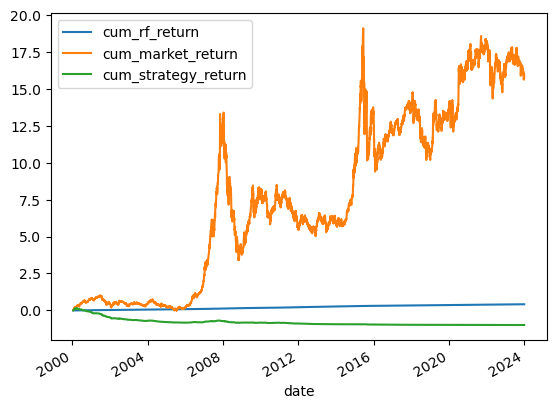

In [146]:
long_only[['cum_rf_return', 'cum_market_return', 'cum_strategy_return']].plot()

In [147]:
long_short['cum_rf_return'] = long_short['rf']
long_short.iloc[0, 5] -= 0.0024  # we buy rf at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_short['cum_rf_return'] = (1+long_short['cum_rf_return']).cumprod()
long_short['cum_rf_return'] -= 1
long_short.iloc[long_short.shape[0] - 1, 5] -= 0.0034  # we sell rf at the end of the period, so we need to minus the transaction cost

long_short['cum_market_return'] = long_short['market_return']
long_short.iloc[0, 6] -= 0.0024  # we buy market at the beginning of the period, and sell at the end of the period, so we need to minus the transaction cost
long_short['cum_market_return'] = (1+long_short['cum_market_return']).cumprod()
long_short['cum_market_return'] -= 1
long_short.iloc[long_short.shape[0] - 1, 6] -= 0.0034  # we sell market at the end of the period, so we need to minus the transaction cost

long_short['if_Monday'] = long_short['date'].dt.day_name() == "Monday"
long_short['if_Monday'] = long_short['if_Monday'].astype(int)
long_short['cum_strategy_return'] = (long_short['long_short'] - 0.0058)* long_short['if_Monday'] + long_short['rf']*(1-long_short['if_Monday'])
long_short['cum_strategy_return'] = (1+long_short['cum_strategy_return']).cumprod()
long_short['cum_strategy_return'] -= 1

long_short.tail(5)

,long_short,date,rf,mkt_risk_premium,market_return,cum_rf_return,cum_market_return,if_Monday,cum_strategy_return
date,,,,,,,,,
2023-12-22,-0.014716,2023-12-22,0.000041,0.000092,0.000133,0.41439,16.942308,0,-0.980014
2023-12-25,-0.005922,2023-12-25,0.000041,0.002024,0.002065,0.414448,16.979359,1,-0.980248
2023-12-26,-0.009729,2023-12-26,0.000041,-0.005553,-0.005512,0.414506,16.880257,0,-0.980248
2023-12-27,0.007470,2023-12-27,0.000041,0.006401,0.006442,0.414564,16.995441,0,-0.980247
2023-12-28,0.021625,2023-12-28,0.000041,0.012819,0.01286,0.411222,17.223463,0,-0.980246


<Axes: xlabel='date'>

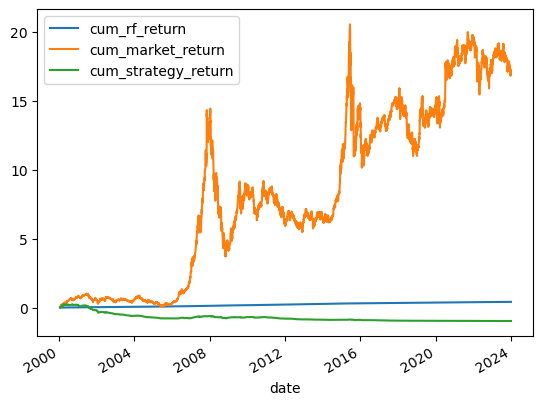

In [148]:
long_short[['cum_rf_return', 'cum_market_return', 'cum_strategy_return']].plot()

In [149]:
long_only['day_kind'] = long_only['date'].dt.day_name()
long_short['day_kind'] = long_short['date'].dt.day_name()

long_only_monday = long_only[long_only['day_kind'] == 'Monday']
long_short_monday = long_short[long_short['day_kind'] == 'Monday']

In [150]:
long_only_monday[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_only,rf,market_return
mean,0.001630,0.000060,0.001573
std,0.021096,0.000019,0.020850
min,-0.097229,0.000041,-0.094029
max,0.093116,0.000111,0.296699
skew,-0.462041,0.884945,2.144305
kurt,3.020990,0.068318,37.359876


In [151]:
long_short_monday[['long_short', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_short,rf,market_return
mean,0.002370,0.000060,0.001570
std,0.022848,0.000019,0.020864
min,-0.097923,0.000041,-0.094029
max,0.098386,0.000111,0.296699
skew,-0.732196,0.884364,2.144217
kurt,3.194583,0.063163,37.327920


## 2.7 backtesting on momentum

In [152]:
daily_stock_return.head(20)

,Stkcd,date,daily_stock_return,rf,excess_return,market_value,day_kind,total_assets,total_shareholders_equity,BM ratio,...,INV*Monday_loading,MOM*Monday_loading,REV*Monday_loading,mkt_risk_premium*Monday_loading,new_size_tag,new_size_tag t - 1,new_bm_tag,new_bm_tag t - 1,rule,rule t - 1
227,000001,2000-12-18,0.000655,0.0225,-0.021845,2.971270e+10,Monday,6.722750e+10,4.738884e+09,0.159490,...,0.019696,-0.488649,0.295069,-1.900877,1,1.0,0.0,0.0,10.0,1
228,000001,2000-12-19,-0.020956,0.0225,-0.043456,2.909004e+10,Tuesday,6.722750e+10,4.738884e+09,0.162904,...,0.030625,-0.630968,0.212186,-4.833115,1,1.0,0.0,0.0,10.0,1
229,000001,2000-12-20,-0.006020,0.0225,-0.028520,2.891492e+10,Wednesday,6.722750e+10,4.738884e+09,0.163891,...,0.032336,-0.664924,0.177225,-4.906533,1,1.0,0.0,0.0,10.0,1
230,000001,2000-12-21,-0.002692,0.0225,-0.025192,2.883708e+10,Thursday,6.722750e+10,4.738884e+09,0.164333,...,0.033468,-0.687391,0.154094,-4.955109,1,1.0,0.0,0.0,10.0,1
231,000001,2000-12-22,-0.011471,0.0225,-0.033971,2.850629e+10,Friday,6.722750e+10,4.738884e+09,0.166240,...,0.015957,-0.330621,-0.081940,-3.504572,1,1.0,0.0,0.0,10.0,1
232,000001,2000-12-25,-0.017747,0.0225,-0.040247,2.800038e+10,Monday,6.722750e+10,4.738884e+09,0.169244,...,0.019920,-0.409046,-0.110136,-3.487403,1,1.0,0.0,0.0,10.0,1
233,000001,2000-12-26,0.000695,0.0225,-0.021805,2.801984e+10,Tuesday,6.722750e+10,4.738884e+09,0.169126,...,0.029298,-0.580894,-1.295529,-3.528409,1,1.0,0.0,0.0,10.0,1
234,000001,2000-12-27,-0.001389,0.0225,-0.023889,2.798092e+10,Wednesday,6.722750e+10,4.738884e+09,0.169361,...,0.022389,-0.445933,-1.504522,-3.501076,1,1.0,0.0,0.0,10.0,1
235,000001,2000-12-28,-0.001391,0.0225,-0.023891,2.794201e+10,Thursday,6.722750e+10,4.738884e+09,0.169597,...,0.026629,-0.528754,-1.376270,-3.517849,1,1.0,0.0,0.0,10.0,1
236,000001,2000-12-29,0.011142,0.0225,-0.011358,2.825334e+10,Friday,6.722750e+10,4.738884e+09,0.167728,...,0.020617,-0.411308,-1.558140,-3.494063,1,1.0,0.0,0.0,10.0,1


according to our definition, momentum factor is the cumulative return of past 12 days, and reversal is the return of the past 1 day. So we can use the negative reversal as the momentum

In [153]:
tmp = daily_stock_return.groupby(['date', 'reversal_tag'], observed=False).apply(lambda x: np.average(x['daily_stock_return'], weights=x['market_value']), include_groups=False).unstack()

In [154]:
long_only = tmp[9]
long_short = tmp[9] - tmp[0]

In [155]:
long_only = pd.DataFrame(long_only)
long_only.columns = ['long_only']
long_short = pd.DataFrame(long_short)
long_short.columns = ['long_short']

In [156]:
long_only['date'] = long_only.index
long_short['date'] = long_short.index

In [157]:
# merge rf and market return to long_only and long_short
long_only['rf'] = long_only['date'].map(rf.set_index('date')['daily_rf'])
long_only['mkt_risk_premium'] = long_only['date'].map(factor_data.set_index('date')['mkt_risk_premium'])
long_only['market_return'] = long_only['mkt_risk_premium'] + long_only['rf']

long_short['rf'] = long_short['date'].map(rf.set_index('date')['daily_rf'])
long_short['mkt_risk_premium'] = long_short['date'].map(factor_data.set_index('date')['mkt_risk_premium'])
long_short['market_return'] = long_short['mkt_risk_premium'] + long_short['rf']

In [158]:
long_only['day_kind'] = long_only['date'].dt.day_name()
long_short['day_kind'] = long_short['date'].dt.day_name()

In [159]:
long_only_monday = long_only[long_only['day_kind'] == 'Monday']
long_short_monday = long_short[long_short['day_kind'] == 'Monday']

In [160]:
long_only_monday[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt']).to_excel(r'output/part2/Monday Anomaly long only.xlsx')
long_short_monday[['long_short', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt']).to_excel(r'output/part2/Monday Anomaly long short.xlsx')

In [161]:
long_only_monday[['long_only', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_only,rf,market_return
mean,0.007087,0.000060,0.001573
std,0.022096,0.000019,0.020850
min,-0.092575,0.000041,-0.094029
max,0.099433,0.000111,0.296699
skew,0.119231,0.884945,2.144305
kurt,2.512467,0.068318,37.359876


In [162]:
long_short_monday[['long_short', 'rf', 'market_return']].agg(['mean', 'std', 'min', 'max', 'skew', 'kurt'])

,long_short,rf,market_return
mean,0.008568,0.000060,0.001573
std,0.016888,0.000019,0.020850
min,-0.068296,0.000041,-0.094029
max,0.106276,0.000111,0.296699
skew,0.583803,0.884945,2.144305
kurt,3.150199,0.068318,37.359876
